In [2]:
%config IPCompleter.greedy=True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [4]:
#ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
#movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
#tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
#links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')

In [5]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/movies.csv')

# Dataset

In [6]:
percentage = 1
#movies_df = movies_df.head(int(len(movies_df)*(percentage/100)))
ratings_df = ratings_df.head(int(len(ratings_df)*(percentage/100)))

In [7]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [369]:
ratings_df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
249995,1751,161,3.0,945125051
249996,1751,163,2.0,945127081
249997,1751,164,1.0,945126546
249998,1751,175,5.0,945124825


In [9]:
#ratings_df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [10]:
num_users = ratings_df['userId'].unique()
print(len(num_users))
num_items = ratings_df['movieId'].unique()
print(len(num_items))

1751
13989


# Spotlight

## Data preperation for Spotlight

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used when needed.

In [11]:
from collections import defaultdict
from itertools import count
uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (1, uid_map[3]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 1 got uid 2
movieId 54001 got iid 557


Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

## Implicit Factorization model

In [12]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids,
                                   timestamps = timestamps)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train_tmp, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))
implicit_train, implicit_val = random_train_test_split(implicit_train_tmp, random_state=np.random.seed(42))
implicit_train_features, implicit_train_labels = random_train_test_split(implicit_train, random_state=np.random.seed(42))

In [13]:
print(implicit_train)
print(implicit_test)
print(implicit_val)
print(implicit_train_features)
print(implicit_train_labels)

<Interactions dataset (1751 users x 13989 items x 160000 interactions)>
<Interactions dataset (1751 users x 13989 items x 50000 interactions)>
<Interactions dataset (1751 users x 13989 items x 40000 interactions)>
<Interactions dataset (1751 users x 13989 items x 128000 interactions)>
<Interactions dataset (1751 users x 13989 items x 32000 interactions)>


### Train-test split to DataFrame

Train and test interaction datasets are converted to dataframes, in order to be used from other models too and provide consistent and fair results.

In [14]:
def interactionToDataFrame(dataset):
    converted_users = []
    converted_movies = []
    rating = []
    #FOR EACH INTERACTION
    for i in range(len(dataset.user_ids)):
        converted_users.append(uid_rev_map[dataset.user_ids[i]])
        converted_movies.append(iid_rev_map[dataset.item_ids[i]])
        rating.append(float(ratings_df['rating'][(ratings_df['movieId'] == converted_movies[i]) & (
            ratings_df['userId'] == converted_users[i])].values))

    df = pd.DataFrame({'user_id': converted_users,
                       'movie_id': converted_movies, 'rating': rating})
    return df

In [15]:
train_df = interactionToDataFrame(implicit_train)
val_df = interactionToDataFrame(implicit_val)
test_df = interactionToDataFrame(implicit_test)
train_features_df = interactionToDataFrame(implicit_train_features)
train_labels_df = interactionToDataFrame(implicit_train_labels)

### Pickle 

Save

In [16]:
'''train_df.to_pickle("./train_df.pkl")
test_df.to_pickle("./test_df.pkl")
val_df.to_pickle("./val_df.pkl")'''

'train_df.to_pickle("./train_df.pkl")\ntest_df.to_pickle("./test_df.pkl")\nval_df.to_pickle("./val_df.pkl")'

Load

In [17]:
'''train_df = pd.read_pickle("./train_df.pkl")
test_df = pd.read_pickle("./test_df.pkl")
val_df = pd.read_pickle("./val_df.pkl")'''

'train_df = pd.read_pickle("./train_df.pkl")\ntest_df = pd.read_pickle("./test_df.pkl")\nval_df = pd.read_pickle("./val_df.pkl")'

### Train Implicit Factorization model 

In [18]:
implicit_model = ImplicitFactorizationModel(n_iter=5)

current = time.time()

implicit_model.fit(implicit_train, verbose=True)

end = time.time()
diff = end - current
print('Training took %d second' % (diff))

Epoch 0: loss 0.555300911617279
Epoch 1: loss 0.34304434409141543
Epoch 2: loss 0.3087792643785477
Epoch 3: loss 0.28004164180755614
Epoch 4: loss 0.2514828246116638
Training took 89 second


Distribution of scores for a user

(array([2.000e+00, 2.000e+00, 3.000e+00, 1.200e+01, 1.900e+01, 3.800e+01,
        9.000e+01, 1.510e+02, 2.540e+02, 4.190e+02, 7.660e+02, 1.142e+03,
        1.522e+03, 1.675e+03, 1.500e+03, 1.201e+03, 7.780e+02, 5.960e+02,
        4.890e+02, 4.280e+02, 3.970e+02, 3.470e+02, 3.090e+02, 2.310e+02,
        2.010e+02, 2.050e+02, 1.870e+02, 2.020e+02, 1.910e+02, 1.870e+02,
        1.620e+02, 1.080e+02, 8.000e+01, 4.700e+01, 2.800e+01, 9.000e+00,
        4.000e+00, 2.000e+00, 4.000e+00, 1.000e+00]),
 array([-15.1200285 , -14.397862  , -13.675697  , -12.953531  ,
        -12.231365  , -11.509199  , -10.787034  , -10.064868  ,
         -9.342702  ,  -8.620537  ,  -7.8983707 ,  -7.176205  ,
         -6.454039  ,  -5.7318735 ,  -5.0097075 ,  -4.287542  ,
         -3.565376  ,  -2.8432102 ,  -2.1210446 ,  -1.3988788 ,
         -0.676713  ,   0.04545278,   0.76761854,   1.4897844 ,
          2.21195   ,   2.934116  ,   3.6562817 ,   4.3784475 ,
          5.100613  ,   5.822779  ,   6.544945  ,   7.

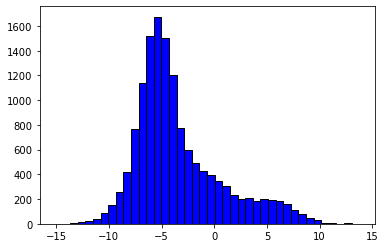

In [19]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Not a lot items with high score

### Top-K predictions for a user

The function below (allUsers_topK_implicit) returns a list that contains the top-K recommendations for each user.

In [20]:
import scipy.stats as st
k = 100
def topK_implicit(user, model, k=100):
  a= list()
  ranks = st.rankdata(-model.predict(user))   
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = topK_implicit(0,implicit_model)
print(rec_forUser)

[306, 307, 2068, 5878, 6016, 7318, 953, 1196, 1201, 2571, 3148, 3578, 4299, 4993, 8958, 293, 741, 912, 1208, 1221, 1252, 3753, 4226, 4369, 4979, 5291, 48774, 2716, 235, 337, 1235, 308, 16, 21, 750, 903, 904, 923, 1207, 1258, 1721, 954, 1084, 1219, 515, 908, 910, 1673, 1876, 2318, 2395, 2908, 2973, 2997, 3317, 3435, 3499, 3633, 3967, 4002, 6385, 3147, 6936, 5995, 2010, 2313, 529, 1172, 1228, 1945, 3623, 965, 1078, 2018, 2731, 6957, 4239, 1263, 1245, 3104, 3470, 7063, 1256, 2076, 3468, 916, 2687, 4033, 4008, 3504, 4326, 2594, 3424, 946, 1178, 3022, 4881, 3007, 3078, 3676]


In [21]:
def allUsers_topK_implicit(model):
    a = []
    for i in range(len(num_users)):
       a.append(topK_implicit(i,model))
    return a

In [22]:
movies_df.loc[movies_df['movieId'].isin(rec_forUser)]

,movieId,title,genres
15,16,Casino (1995),Crime|Drama
20,21,Get Shorty (1995),Comedy|Crime|Thriller
232,235,Ed Wood (1994),Comedy|Drama
289,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
302,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
...,...,...,...
6832,6957,Bad Santa (2003),Comedy|Crime
6938,7063,"Aguirre: The Wrath of God (Aguirre, der Zorn G...",Adventure|Drama
7193,7318,"Passion of the Christ, The (2004)",Drama
8243,8958,Ray (2004),Drama


In [23]:
movies_pred = movies_df['movieId'][movies_df['movieId'].isin(rec_forUser)]

### Μovies watched from a user

In [24]:
actual = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(100)

In [25]:
actual = actual.index.tolist()

In [26]:
movies_df.loc[movies_df['movieId'].isin(actual)]

,movieId,title,genres
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
302,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
303,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
654,665,Underground (1995),Comedy|Drama|War
878,899,Singin' in the Rain (1952),Comedy|Musical|Romance
...,...,...,...
9122,27193,Taxi 2 (2000),Action|Comedy
9145,27266,2046 (2004),Drama|Fantasy|Romance|Sci-Fi
9306,27721,"Very Long Engagement, A (Un long dimanche de f...",Drama|Mystery|Romance|War
9647,31956,5x2 (2004),Drama|Romance


In [27]:
movies_watched = movies_df['movieId'][movies_df['movieId'].isin(actual)]

### NDCG Score

In [28]:
allUsers_topK_imp = allUsers_topK_implicit(implicit_model)

In [29]:
rec_forUser == allUsers_topK_imp[0]

True

In [30]:
relevance_implicit = []
for i in range(len(rec_forUser)):
    if rec_forUser[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_implicit.append(1)
    else:
        relevance_implicit.append(0)
    

Compute the relevance for each user. The relevance containes 0s and 1s based on which movies each has watched. For every recommended movie that the user has actually watched, the value of 1 is assigned. There is a relevance list for each user.

In [31]:
def relevance_spotlight_implicit(allUsers_topK):
    relevance_implicit_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(allUsers_topK[count])):
            if allUsers_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_implicit_full.append(helper)
        helper = []
        count += 1
    return relevance_implicit_full

In [32]:
relevance_implicit_full = relevance_spotlight_implicit(allUsers_topK_imp)

In [33]:
relevance_implicit == relevance_implicit_full[0]

True

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [34]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [35]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

In [36]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

In [37]:
ndcg = NDCG_forUser(relevance_implicit_full[0])
print(ndcg)
ndcg = NDCG_forUser(relevance_implicit)
print(ndcg)

1.0
1.0


Creation of a list (allUsers_implicit_ndcg) that contains the NDCG score for each user.

In [38]:
def allUsers_ndcg(relevance):
    allUsers_implicit_ndcg = []
    for i in range(len(num_users)):
        allUsers_implicit_ndcg.append(NDCG_forUser(relevance[i]))
    return allUsers_implicit_ndcg

In [39]:
allUsers_implicit_ndcg = allUsers_ndcg(relevance_implicit_full)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Fill the nan values with 0s.

In [40]:
allUsers_implicit_ndcg = pd.Series(allUsers_implicit_ndcg).fillna(0).tolist()

In [41]:
np.array(allUsers_implicit_ndcg).mean()

0.3376332003841967

### MRR Score

In [42]:
#Calculate reciprocal rank. Where is the first relevant item?
def RR_forUsers(relevance):
    count = 0
    reciprocal_rank_perUser = []
    #for each user
    first_perUser = 0
    for rel in relevance:
        #for each item in a relevance list
        for r in rel:
            count += 1
            if r == 1:
                #1/position
                first_perUser = 1/count
                #stop the iteration. Only care about the first relevant item
                break
        reciprocal_rank_perUser.append(first_perUser)
        count = 0
    return reciprocal_rank_perUser

In [43]:
rr_implicit = RR_forUsers(relevance_implicit_full)

In [44]:
def calculate_mrr(rr):    
    #or np.array(rr).mean()
    return np.array(rr).sum()/len(rr)

In [45]:
implicit_mrr = calculate_mrr(rr_implicit)

In [46]:
implicit_mrr

0.2215410091878409

### MAP Score

In [47]:
#calculate average precision.
def calculate_averagePrecision(relevance):
    count_positive = 0
    positives = []
    ap_perUser = []
    count = 0
    #for each user
    for rel in relevance:
        #for each item in a relevance list
        for r in rel:
            count += 1
            if r == 1:
                count_positive += 1
                #First, second, etc. relevant item/ position
                positives.append(count_positive/count)
        #mean of relevant item/position
        ap_perUser.append(np.array(positives).sum()/count_positive)
        count_positive = 0
        positives = []
        count = 0
    return ap_perUser

In [48]:
implicit_ap = calculate_averagePrecision(relevance_implicit_full)
implicit_ap = pd.Series(implicit_ap).fillna(0).tolist()

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [49]:
def calculate_MAP(ap):
    #or np.array(ap).mean()
    return np.array(ap).sum()/len(ap)

In [50]:
implicit_map = calculate_MAP(implicit_ap)
implicit_map

0.1114408292716409

# SVD

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [51]:
df_movie_features = train_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [371]:
df_movie_features

movie_id,1,2,3,4,5,6,7,8,9,10,...,205945,205967,206272,206293,206499,206523,206805,206861,207309,208002
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1748,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD implementation

In [53]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_movie_features, k = 10)

## Predictions

To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [54]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_movie_features.columns)


In [55]:
svd_predictions_score[1]

array([ 1.85530416e+00,  4.69230956e-01,  2.59108323e-01, ...,
       -2.05918746e-02,  8.78561664e-04, -3.39968465e-04])

In [56]:
svd_predictions_score_df

movie_id,1,2,3,4,5,6,7,8,9,10,...,205945,205967,206272,206293,206499,206523,206805,206861,207309,208002
0,0.032771,0.030239,-0.032999,-0.011364,-0.021276,-0.079667,-0.061276,0.000744,-0.047291,0.012681,...,0.001374,-0.006984,-0.000607,-0.000163,0.030769,0.002015,0.001085,-0.004989,0.000450,-0.000635
1,1.855304,0.469231,0.259108,-0.006175,0.176600,-0.186226,0.398078,0.036560,-0.027059,0.467862,...,0.001670,-0.028829,0.001668,0.006813,0.011619,0.004801,0.001219,-0.020592,0.000879,-0.000340
2,1.383784,0.512538,-0.334716,-0.080378,-0.269220,0.586584,-0.329729,-0.074371,0.034845,0.185844,...,0.000367,0.080151,0.024640,0.021946,-0.000903,0.028733,0.005882,0.057251,0.037212,0.031329
3,1.800220,0.300380,-0.119851,-0.024638,-0.004346,-0.143085,-0.091895,-0.028053,-0.007167,0.134099,...,0.000941,0.024366,0.019011,0.014194,0.005220,0.015711,0.001466,0.017404,0.015170,0.013704
4,1.110384,0.514500,0.318426,0.063635,0.302297,0.648988,0.375785,0.068388,0.158059,0.929522,...,-0.000359,-0.008906,-0.001130,0.000430,-0.008203,0.000929,0.000959,-0.006362,-0.000034,-0.000993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746,0.273779,-0.014916,0.057588,0.028973,0.009918,0.426969,0.091392,0.003454,0.014986,0.141663,...,-0.000808,-0.003002,-0.001254,-0.005551,-0.005522,0.001416,0.001813,-0.002144,0.008828,0.007016
1747,-3.891613,-0.121856,1.317114,0.311301,0.581930,3.631546,4.034761,0.249082,0.333966,0.508059,...,-0.016812,0.097286,-0.036449,0.029685,0.052336,-0.000035,0.017789,0.069490,0.050039,0.032250
1748,1.029848,0.232918,0.323010,0.063387,0.189893,0.465142,0.432671,0.025448,0.094075,0.312374,...,-0.000586,0.008472,-0.000438,0.001178,-0.004295,-0.004171,-0.001949,0.006051,-0.005285,-0.003337
1749,0.249576,0.042079,0.041598,0.007116,0.030583,-0.004638,0.071874,0.004459,0.002458,0.020888,...,0.000262,-0.003600,0.000169,0.000814,0.001473,0.000205,-0.000039,-0.002572,-0.000664,-0.000625


In [57]:
svd_predictions_score_df[svd_predictions_score_df.index == 609]

movie_id,1,2,3,4,5,6,7,8,9,10,...,205945,205967,206272,206293,206499,206523,206805,206861,207309,208002
609,1.070007,0.290388,-0.034111,-0.034238,-0.054393,0.065197,-0.178301,-0.017917,-0.071763,0.2121,...,0.002238,0.005911,0.005469,0.002303,0.010929,0.007163,0.001808,0.004222,0.007683,0.005875


## Top-K recommendations

The function below returns a list that contains the top-100 recommendations for each user

In [58]:
svd_predictions_score_df[svd_predictions_score_df.index == 0].values[0]

array([ 0.03277133,  0.03023935, -0.03299935, ..., -0.00498884,
        0.00044983, -0.00063537])

In [59]:
def SVD_topK_first(score_df):
    topK_svd_rec = []
    for i in range(len(num_users)):
        svd_h_df = pd.DataFrame({'movie_id': score_df[score_df.index == i].columns,
                                 'score': score_df[score_df.index == i].values[0]})
        svd_h_df = svd_h_df.sort_values('score', ascending=False)
        svd_h_df = svd_h_df.head(100)
        topK_svd_rec.append(svd_h_df['movie_id'].values)
    return topK_svd_rec

In [60]:
a = SVD_topK_first(svd_predictions_score_df)

In [61]:
a[0]

array([ 4973,  2959,  4993,  7361,  6377,  5952,  6711,  4306,  8961,
        7153,  6874,  6539,  4878,  4226,  5989,  4886,  2858,  5669,
        4011, 46578,  5445,  7438,  5418,  2571,  7147,    47,  1682,
        6016,  6333, 48394,  8874,  4027,  2997,  4963,  2692,  1732,
        3996,  3578,  2329, 60069,  2542,  4979,  3481,  8360,  8368,
        5349,  3949,   778,  5618,  3147,  4720,  4896,   356,  5995,
       33794,  8949,   750,  3751, 50872,  3114, 68954, 58559,  2324,
       30707, 56367,  8665, 31658,  3793,  2291,  3994, 48516,  8784,
        4995,  1089,  8636,  2355, 32587,  1206,  3000,  4022,  6947,
        5971,  4235,   527,  5377,  4014,  2502, 44191,  1246, 33166,
        3897,  8970,  4848,  8873,  8638,  2918, 48774,  4975,  7143,
       48780], dtype=int64)

## NDCG Score

The function below returns the relevance list of a list of movies.

In [62]:
def SVD_relevance_first(score_df):
    svd_topK = SVD_topK_first(score_df)
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full

In [63]:
relevance_first = SVD_relevance_first(svd_predictions_score_df)

In [64]:
np.asarray(relevance_first).shape

(1751, 100)

In [65]:
n_f = NDCG_forUser(relevance_first[0])

In [66]:
n_f

0.2590231125623118

Below is the NDCG scores of each user

In [67]:
all_ndcg_f = allUsers_ndcg(relevance_first)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [68]:
all_ndcg_f = pd.Series(all_ndcg_f).fillna(0).tolist()

In [69]:
np.asarray(all_ndcg_f).mean()

0.4043802855858314

## MRR Score

In [70]:
svd_rr = RR_forUsers(relevance_first)
svd_mrr = calculate_mrr(svd_rr)
svd_mrr

0.25504805717658047

## MAP Score

In [71]:
svd_ap = calculate_averagePrecision(relevance_first)
svd_ap = pd.Series(svd_ap).fillna(0).tolist()
svd_map = calculate_MAP(svd_ap)
svd_map

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


0.14349375194977199

# Feature Engineering 

At this Chapter the goal is to create features to give as an input to the lightGBM model.

##  Feature 1 (Implicit factorization model scores)

Train an implicit factorization model using the train_features dataset

In [72]:
f1_model = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

f1_model.fit(implicit_train_features,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.6085539535284042
Epoch 1: loss 0.3444703742861748
Epoch 2: loss 0.30825371253490447
Epoch 3: loss 0.27293566808104514
Epoch 4: loss 0.24322038605809213
Training took 66 second


### Target Movies

In [73]:
#allUsers_topK_f1 = allUsers_topK_implicit(f1_model)
#target_positive = allUsers_topK_f1

In [74]:
def getImplicitTop():
    moviePerUser = []
    rev = []
    for user in range(len(num_users)):
        pred = f1_model.predict(user)
        #sort by score in descending order oscer
        predMovieId = np.argsort(-pred)
        #keep top 100
        predMovieId = predMovieId[:100]
        #reverse the mapping to get the original movieIDs
        for movie in predMovieId:
            rev.append(iid_rev_map[movie])
        moviePerUser.append(rev)
        rev = []
    return moviePerUser

In [75]:
target_positive = getImplicitTop()

Add negative samples to the target movies

In [76]:
import random
target_negative = []
for i in range(1,len(num_users)+1):
    #get 50 random movieIDs for each user
    target_negative.append(random.choices(train_features_df['movie_id'].values, k = 50))

Merge the top-100 and the negative samples to provide the target movies.

In [77]:
target_movies = []
for i in range(len(num_users)):
    target_movies.append(target_positive[i] + target_negative[i])

Map the target movies to pick the correct predictions based on the item id

In [78]:
def map_movies(target_movies):
    map_target_movies = []
    map_help = []
    for movies in target_movies:
        for movie in movies:
            map_help.append(iid_map[movie])
        map_target_movies.append(map_help)
        map_help = []
    return map_target_movies

In [79]:
def give_movies_implicit_scores(map_movies):
    implicit_scores = 0
    feature = []
    for i in range(len(num_users)):
        #for movies in map_target_movies:
        my_list = map_movies[i]
        my_array = np.array(my_list)
        implicit_scores = f1_model.predict(user_ids = i,item_ids = my_array)
        feature.append(implicit_scores)
    return feature

In [80]:
map_target_movies = map_movies(target_movies)
feature1 = give_movies_implicit_scores(map_target_movies)
feature1 = np.asarray(feature1)

In [81]:
feature1[0]

array([ 14.026933  ,  12.409852  ,  12.303709  ,  11.927846  ,
        11.774894  ,  11.751321  ,  11.72087   ,  11.653933  ,
        11.582903  ,  11.442561  ,  11.420834  ,  11.366281  ,
        11.337953  ,  11.255153  ,  11.221572  ,  11.218789  ,
        11.177646  ,  11.165468  ,  11.091574  ,  11.071485  ,
        11.035355  ,  11.026826  ,  11.018308  ,  11.012863  ,
        11.003664  ,  10.916847  ,  10.843989  ,  10.808976  ,
        10.799676  ,  10.7939    ,  10.775166  ,  10.759803  ,
        10.736603  ,  10.637561  ,  10.609142  ,  10.606955  ,
        10.56084   ,  10.54107   ,  10.486349  ,  10.47295   ,
        10.437531  ,  10.432902  ,  10.4081955 ,  10.391855  ,
        10.383073  ,  10.364211  ,  10.31798   ,  10.296441  ,
        10.285156  ,  10.275506  ,  10.260109  ,  10.241531  ,
        10.239169  ,  10.222952  ,  10.217089  ,  10.173728  ,
        10.172043  ,  10.156681  ,  10.153753  ,  10.153592  ,
        10.123776  ,  10.12146   ,  10.103248  ,  10.08

## Feature 2 (Implicit Rank)

In [82]:
feature2 = []
for i in range(len(num_users)):
    #my_list = map_target_movies[i]
    #my_array = np.array(my_list)
    feature2 = (st.rankdata(-f1_model.predict(i)))
    feature2 = feature2[map_target_movies]
    feature2.sort()

In [83]:
feature2[0]

array([1.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
       7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01, 1.000e+01, 1.100e+01,
       1.300e+01, 1.300e+01, 1.400e+01, 1.500e+01, 1.700e+01, 1.900e+01,
       2.000e+01, 2.200e+01, 2.400e+01, 2.400e+01, 2.500e+01, 2.800e+01,
       3.200e+01, 3.300e+01, 3.400e+01, 3.400e+01, 3.500e+01, 3.800e+01,
       4.000e+01, 4.300e+01, 4.400e+01, 4.500e+01, 4.600e+01, 4.700e+01,
       4.900e+01, 5.100e+01, 5.300e+01, 5.600e+01, 6.200e+01, 6.500e+01,
       6.600e+01, 6.700e+01, 7.000e+01, 7.200e+01, 7.400e+01, 7.600e+01,
       8.100e+01, 8.200e+01, 8.300e+01, 8.500e+01, 8.500e+01, 8.500e+01,
       8.800e+01, 9.000e+01, 9.200e+01, 1.060e+02, 1.170e+02, 1.190e+02,
       1.280e+02, 1.320e+02, 1.350e+02, 1.380e+02, 1.390e+02, 1.410e+02,
       1.430e+02, 1.470e+02, 1.490e+02, 1.540e+02, 1.560e+02, 1.590e+02,
       1.620e+02, 1.660e+02, 1.670e+02, 1.800e+02, 1.810e+02, 1.870e+02,
       1.990e+02, 2.060e+02, 2.060e+02, 2.140e+02, 

In [84]:
feature2 = np.array(feature2)

In [85]:
print(feature2.shape)
feature2[0][0:150]

(1751, 150)


array([1.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 5.000e+00,
       7.000e+00, 8.000e+00, 9.000e+00, 1.000e+01, 1.000e+01, 1.100e+01,
       1.300e+01, 1.300e+01, 1.400e+01, 1.500e+01, 1.700e+01, 1.900e+01,
       2.000e+01, 2.200e+01, 2.400e+01, 2.400e+01, 2.500e+01, 2.800e+01,
       3.200e+01, 3.300e+01, 3.400e+01, 3.400e+01, 3.500e+01, 3.800e+01,
       4.000e+01, 4.300e+01, 4.400e+01, 4.500e+01, 4.600e+01, 4.700e+01,
       4.900e+01, 5.100e+01, 5.300e+01, 5.600e+01, 6.200e+01, 6.500e+01,
       6.600e+01, 6.700e+01, 7.000e+01, 7.200e+01, 7.400e+01, 7.600e+01,
       8.100e+01, 8.200e+01, 8.300e+01, 8.500e+01, 8.500e+01, 8.500e+01,
       8.800e+01, 9.000e+01, 9.200e+01, 1.060e+02, 1.170e+02, 1.190e+02,
       1.280e+02, 1.320e+02, 1.350e+02, 1.380e+02, 1.390e+02, 1.410e+02,
       1.430e+02, 1.470e+02, 1.490e+02, 1.540e+02, 1.560e+02, 1.590e+02,
       1.620e+02, 1.660e+02, 1.670e+02, 1.800e+02, 1.810e+02, 1.870e+02,
       1.990e+02, 2.060e+02, 2.060e+02, 2.140e+02, 

## Feature 3 (SVD scores)

SVD model Scores. Take advantage of the DataFrame containing the scores to extract the predicted scores for the desired movies.

In [86]:
df_movie_features1 = train_features_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [87]:
U1, sigma1, Vt1 = svds(df_movie_features1)
sigma1 = np.diag(sigma1)
svd_predictions_score1 = np.dot(np.dot(U1, sigma1), Vt1)
svd_predictions_score_df1 = pd.DataFrame(svd_predictions_score1, columns = df_movie_features1.columns)

In [88]:
svd_predictions_score_df1[svd_predictions_score_df1.index == 0]

movie_id,1,2,3,4,5,6,7,8,9,10,...,205072,205156,205557,205945,205967,206293,206499,206523,206805,207309
0,0.015467,-0.051232,-0.034518,-0.007617,-0.025463,0.006996,-0.036795,-0.009753,-0.033439,-0.062334,...,0.001048,0.045878,-0.004946,0.000492,-0.000088,-0.001027,0.022939,0.002392,0.0011,0.0011


In [89]:
float(svd_predictions_score_df1[svd_predictions_score_df1.index == 0][target_movies[0][0]].values)

0.33427012361295133

In [90]:
feature3 = []
feature3_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature3_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature3.append(feature3_user)
    feature3_user = []

In [374]:
np.array(feature3).shape

(1751, 150)

## Feature 4 (Genre)

In [92]:
def create_genre_feature(genre):
    feature = []
    genre_per_user = []
    for i in range(len(num_users)):
        for j in range(len(target_movies[i])):
            a =  movies_df[movies_df['movieId'] == target_movies[i][j]]['genres']
            a = a.tolist()
            a = str(a[0])
            a = a.split('|')
            if genre in a:
                #print(a)
                genre_per_user.append(1)
            else:
                genre_per_user.append(0)
        feature.append(genre_per_user)
        genre_per_user = []
    return feature

In [93]:
feature4 = create_genre_feature('Comedy')
np.array(feature4).shape

(1751, 150)

### Features 8-15 (genres)

In [94]:
feature8 = create_genre_feature('Adventure')
feature9 = create_genre_feature('Drama')
feature10 = create_genre_feature('Romance')
feature11 = create_genre_feature('Fantasy')
feature12 = create_genre_feature('Thriller')
feature13 = create_genre_feature('Animation')
feature14 = create_genre_feature('Children')
feature15 = create_genre_feature('Horror')

## Feature 5 (#Users watched each target movie)

In [95]:
number_views = []
number_view_per_movie = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['movieId'] == target_movies[i][j]]['userId'])
        number_view_per_movie.append(a)
    number_views.append(number_view_per_movie)
    number_view_per_movie = []


In [96]:
feature5 = number_views

In [97]:
np.array(feature5).shape

(1751, 150)

## Feature 6 (New user)

In [98]:
new_users_binary = []
binary_per_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['userId']==i]) < 25
        if a:
            binary_per_user.append(a)
        else:
            binary_per_user.append(a)
    new_users_binary.append(binary_per_user)
    binary_per_user = []

In [99]:
#rankings of old/new users

In [100]:
feature6 = new_users_binary

In [101]:
np.array(feature6).shape

(1751, 150)

Check how many the new users are

In [102]:
count = 0
for i in range(len(num_users)):
    if True in feature6[i]:
        count += 1
print(count)

176


## Feature 7(Embeddings) x32

In [103]:
emb = f1_model._net.item_embeddings

In [104]:
emb_features = []
helper = []
for i in range(32):
    for j in range(len(num_items)):
        helper.append(emb.weight[j][i].item())
    emb_features.append(helper)
    helper = []

In [105]:
a = []
b = []
feature7 = []
for i in range(32):
    for user in range(len(num_users)):
        for movie in map_target_movies[user]:
            a.append(emb_features[0][movie])
        b.append(a)
        a = []
    feature7.append(b)
    b = []

In [106]:
np.array(feature7).shape

(32, 1751, 150)

In [107]:
np.array(feature7[0]).shape

(1751, 150)

## Feature 47 (SVD Rank)

In [108]:
feature47 = []
feature47_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature47_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature47.append(st.rankdata(-np.array(feature47_user)))
    feature47_user = []

In [375]:
'''feature48 = []
for i in range(len(num_users)):
    feature48.append((st.rankdata(-np.array(feature3[i]))))'''

In [109]:
np.array(feature47).shape

(1751, 150)

In [110]:
feature47[0]

array([  8.5,   4. ,  37. ,  20. , 121. ,  85. ,  69. ,  11. , 145. ,
        92.5, 134. ,  14. ,  35. ,  43. , 111.5,  57. ,  34. ,  40.5,
        62. , 119.5,  51. ,  33. , 128. ,  32. ,  22. ,  56. , 117. ,
        10. ,   5. ,  83. , 143. ,  27. ,  38. ,   1. ,  61. ,  73. ,
        24. , 150. , 127. ,  82. ,  50. ,  21. , 142. ,  42. , 146. ,
       139. ,  86. ,  70. ,  59. ,  77. ,   2. ,  72. ,  65. , 137.5,
        28. ,  64. ,  47.5,  44. , 136. ,  46. ,  17. , 110. ,  12. ,
         7. , 122. ,  63. , 144. , 141. ,  45. ,  16. ,  68. ,  30. ,
        91. ,  13. , 118. ,  75. ,  53. , 147. , 129. ,  25.5,  67. ,
       125. , 135. ,   6. ,  94. ,  18. ,  78. ,  55. ,  15. ,  29. ,
         3. ,  95. , 148. , 102. ,  76. ,  23. ,  84. , 149. , 132.5,
        19. ,  88. ,  40.5,  39. ,  74. , 131. , 108. , 126. , 119.5,
        49. , 113. , 105. ,  36. , 100. ,  71. , 114. ,  79. , 130. ,
       132.5,  52. , 115. , 123. ,  59. ,  81. ,  90. , 104. ,  97. ,
       140. ,  80. ,

## Features stack

In [379]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [112]:
features = np.stack((feature1, feature2, feature3,feature4))

In [380]:
lenFeatures = len(features)

## Labels

Below are the movies that each user watched

In [381]:
def watched_movies(df):
    watched = []
    #for i in range(len(num_users)):
    for u in uid_rev_map:
        watched.append(df[df["user_id"]==uid_rev_map.get(u)].groupby("movie_id")["movie_id"].count().index.tolist())  
    return watched 

In [382]:
train_watched = watched_movies(train_labels_df)
test_watched = watched_movies(test_df)
val_watched = watched_movies(val_df)

Creation of the target list. It containes 0s and 1s for the 100 recommended movies for each user. Based on the watched movies it assigns the values. If the user watched the recommended movie, then the value of the target is equal to 1, otherwise it is 0.

In [383]:
def create_target(watched):
    user_target = []
    target = []
    for i in range(len(num_users)):
        for target_movie in target_movies[i]:
            if target_movie in watched[i]:
                user_target.append(1)
            else:
                user_target.append(0)
        target.append(user_target)
        user_target = []
    return target

In [384]:
label_train = create_target(train_watched)
label_test = create_target(test_watched)
label_val = create_target(val_watched)
#y_train = y_test = y_val

# LightGBM 

## Prepare X y

In [385]:
k = len(target_movies[0])

X = np.array(features)
#X = X.reshape(len(num_users)*k,len(features))
X = X.reshape(len(features), len(num_users)*k)
X = np.transpose(X)
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)

In [386]:
y_train = label_train.reshape(len(num_users)*k,)
y_test = label_test.reshape(len(num_users)*k,)
y_val = label_val.reshape(len(num_users)*k,)

In [387]:
X_train = X
X_test = X
X_val = X

## Classifier

In [388]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [389]:
p = 0
m = k
clf_pred_per_user = []
for i in range(len(num_users)):
    clf_pred_per_user.append(y_pred[p:m])
    p += k
    m += k

In [390]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9612


In [391]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    252472
           1       0.00      0.00      0.00     10178

    accuracy                           0.96    262650
   macro avg       0.48      0.50      0.49    262650
weighted avg       0.92      0.96      0.94    262650



In [392]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9754
Test set score: 0.9612


The training and test set accuracy are quite comparable. So, we cannot say there is overfitting.

In [393]:
lgbm_clf_ndcg = NDCG_forUser(y_pred)

In [394]:
lgbm_clf_ndcg

0.1893105674782061

In [395]:
clf_rr = RR_forUsers(clf_pred_per_user)
clf_rr = pd.Series(clf_rr).fillna(0).tolist()

In [396]:
clf_MRR = calculate_mrr(clf_rr)

In [397]:
clf_MRR

0.009289271137829389

In [398]:
clf_ap = calculate_averagePrecision(clf_pred_per_user)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [399]:
clf_ap = pd.Series(clf_ap).fillna(0).tolist()
clf_map = calculate_MAP(clf_ap)
clf_map

0.00013101767121205987

## Ranker

In [400]:
import lightgbm as lgb
param = {
    "task": "train",
    "num_leaves": 255,
    "min_data_in_leaf": 1,
    "min_sum_hessian_in_leaf": 100,
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [1, 5, 10, 20],
    "learning_rate": .1,
    "num_threads": 2,
}
gbm = lgb.LGBMRanker()
gbm.set_params(**param)

LGBMRanker(metric='ndcg', min_data_in_leaf=1, min_sum_hessian_in_leaf=100,
           ndcg_eval_at=[1, 5, 10, 20], num_leaves=255, num_threads=2,
           objective='lambdarank', task='train')

In [401]:
#gbm = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
#                     num_leaves=31, min_child_weight=100)

In [402]:
#print(len(train_df.user_id.unique()))
#print(len(test_df.user_id.unique()))
#print(len(val_df.user_id.unique()))
#print(len(train_features_df.user_id.unique()))
#print(len(train_labels_df.user_id.unique()))

In [403]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
group_train = []
group_val = []
print(query_train)
print(query_val)
print(query_test)

for i in range(len(num_users)):
    group_train.append(k)
    group_val.append(k)

[262650]
[262650]
[262650]


In [415]:
gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_val, y_val)], eval_group=[group_val],
        eval_at=[1, 5, 10, 20], eval_metric='ndcg', verbose = 0)

LGBMRanker(metric='ndcg', min_data_in_leaf=1, min_sum_hessian_in_leaf=100,
           ndcg_eval_at=[1, 5, 10, 20], num_leaves=255, num_threads=2,
           objective='lambdarank', task='train')

In [405]:
gbm.best_iteration_

2

### Predictions

In [416]:
test_pred = gbm.predict(X_test)
np.array(test_pred).shape

(262650,)

In [417]:
p = 0
m = k
lgbm_pred_per_user = []
for i in range(len(num_users)):
    lgbm_pred_per_user.append(test_pred[p:m])
    p += k
    m += k

### NDCG Score

In [418]:
lgbm_NDCG = []
IFM_NDCG = []
SVD_NDCG = []
ifm_relevance_list = []
svd_relevance_list = []
lgbm_relevance_list = []

for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],
                             'rank': feature2[i], 'model2_score': feature3[i],
                             'is_comedy': feature4[i], '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                             'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                             'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank':feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
    excel_df = excel_df.sort_values('model1_score', ascending=False)
    ifm_relevance = excel_df['test_label'].values.tolist()
    ifm_relevance_list.append(ifm_relevance)
    IFM_NDCG.append(NDCG_forUser(ifm_relevance))
    excel_df = excel_df.sort_values('model2_score', ascending=False)
    svd_relevance_h = excel_df['test_label'].values.tolist()
    svd_relevance_list.append(svd_relevance_h)
    SVD_NDCG.append(NDCG_forUser(svd_relevance_h))

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [419]:
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
IFM_NDCG = pd.Series(IFM_NDCG).fillna(0).tolist()
SVD_NDCG = pd.Series(SVD_NDCG).fillna(0).tolist()

# Comparisons

## NDCG 

In [420]:
ndcg_df = pd.DataFrame({'LightGBM': lgbm_NDCG, 'IFM_this': IFM_NDCG, 'SVD_this': SVD_NDCG})

In [421]:
ndcg_df

,LightGBM,IFM_this,SVD_this
0,0.163151,0.151178,0.158635
1,0.492873,0.412345,0.542352
2,0.633394,0.667613,0.548936
3,0.527846,0.648722,0.663853
4,0.459298,0.467642,0.494475
...,...,...,...
1746,0.213649,0.183884,0.238313
1747,0.685916,0.786707,0.767661
1748,0.000000,0.000000,0.000000
1749,0.000000,0.000000,0.000000


In [422]:
lgbm_mean = ndcg_df['LightGBM'].mean()
lgbm_mean

0.3665943926866566

In [423]:
ifm_mean = ndcg_df['IFM_this'].mean()
ifm_mean

0.33621286473343037

In [424]:
svd_mean = ndcg_df['SVD_this'].mean()
svd_mean

0.37956097485413465

## MRR

In [148]:
ifm_rr = RR_forUsers(ifm_relevance_list)
ifm_mrr = calculate_mrr(ifm_rr)
svd_rr = RR_forUsers(svd_relevance_list)
svd_mrr = calculate_mrr(svd_rr)
lgbm_rr = RR_forUsers(lgbm_relevance_list)
lgbm_mrr = calculate_mrr(lgbm_rr)

In [149]:
print('IFM:',ifm_mrr)
print('SVD:',svd_mrr)
print('LightGBM:',lgbm_mrr)

IFM: 0.20258064969324396
SVD: 0.26383552457397624
LightGBM: 0.2448137062390081


## MAP

In [150]:
ifm_ap = calculate_averagePrecision(ifm_relevance_list)
ifm_ap = pd.Series(ifm_ap).fillna(0).tolist()
ifm_map = calculate_MAP(ifm_ap)
svd_ap = calculate_averagePrecision(svd_relevance_list)
svd_ap = pd.Series(svd_ap).fillna(0).tolist()
svd_map = calculate_MAP(svd_ap)
lgbm_ap = calculate_averagePrecision(lgbm_relevance_list)
lgbm_ap = pd.Series(lgbm_ap).fillna(0).tolist()
lgbm_map = calculate_MAP(lgbm_ap)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [151]:
print('IFM:',ifm_map)
print('SVD:',svd_map)
print('LightGBM:',lgbm_map)

IFM: 0.10358576477479803
SVD: 0.144719826602936
LightGBM: 0.12948441124660454


## Visualization

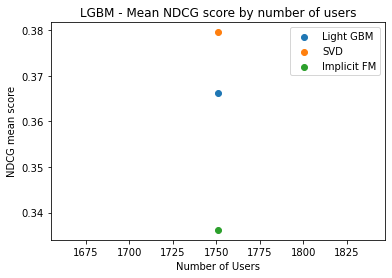

In [152]:
plt.scatter(len(num_users),lgbm_mean,label = 'Light GBM')
plt.scatter(len(num_users),svd_mean, label = 'SVD')
plt.scatter(len(num_users),ifm_mean, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('NDCG mean score')
plt.title('LGBM - Mean NDCG score by number of users')
plt.legend()

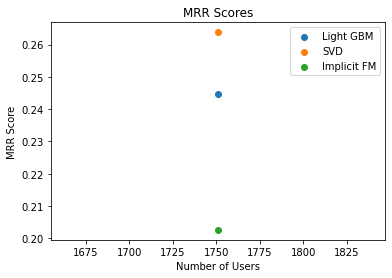

In [153]:
plt.scatter(len(num_users),lgbm_mrr,label = 'Light GBM')
plt.scatter(len(num_users),svd_mrr, label = 'SVD')
plt.scatter(len(num_users),ifm_mrr, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('MRR Score')
plt.title('MRR Scores')
plt.legend()

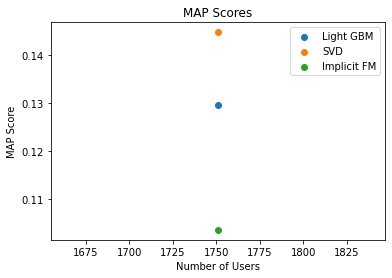

In [154]:
plt.scatter(len(num_users),lgbm_map,label = 'Light GBM')
plt.scatter(len(num_users),svd_map, label = 'SVD')
plt.scatter(len(num_users),ifm_map, label = 'Implicit FM')
plt.xlabel('Number of Users')
plt.ylabel('MAP Score')
plt.title('MAP Scores')
plt.legend()

## Feature Importance

In [155]:
feature_names = excel_df.columns.values[1:5]

In [156]:
len(feature_names)

4

Text(0.5, 1.0, 'Importance of Features')

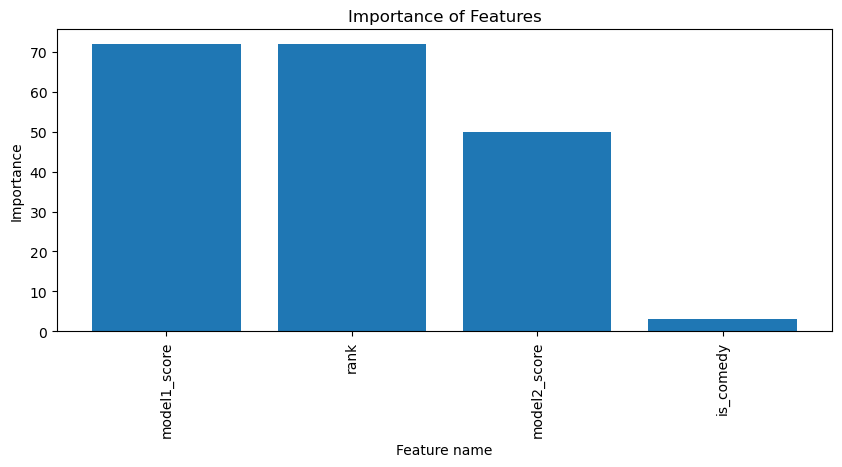

In [157]:
from matplotlib.pyplot import figure
figure(figsize=(10, 4),dpi=100)
plt.bar(feature_names,gbm.feature_importances_)
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature name')
plt.title('Importance of Features')

In [158]:
gbm.feature_importances_

array([72, 72, 50,  3])

## Save comparison

In [159]:
#ndcg_df.to_pickle("./ndcg_f1-15_minus67_100k_negative_rank.pkl")

# Research Questions

In [160]:
'''feature8 = create_genre_feature('Adventure')
feature9 = create_genre_feature('Drama')
feature10 = create_genre_feature('Romance')
feature11 = create_genre_feature('Fantasy')
feature12 = create_genre_feature('Thriller')
feature13 = create_genre_feature('Animation')
feature14 = create_genre_feature('Children')
feature15 = create_genre_feature('Horror')'''

"feature8 = create_genre_feature('Adventure')\nfeature9 = create_genre_feature('Drama')\nfeature10 = create_genre_feature('Romance')\nfeature11 = create_genre_feature('Fantasy')\nfeature12 = create_genre_feature('Thriller')\nfeature13 = create_genre_feature('Animation')\nfeature14 = create_genre_feature('Children')\nfeature15 = create_genre_feature('Horror')"

In [161]:
'''np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))'''

'np.stack((feature1, feature2, feature3, feature4, feature5, feature6,\n                     feature7[0], feature7[1], feature7[2], feature7[3],\n                     feature7[4], feature7[5], feature7[6], feature7[7],\n                     feature7[8], feature7[9], feature7[10], feature7[11],\n                     feature7[12], feature7[13], feature7[14], feature7[15],\n                     feature7[16], feature7[17], feature7[18], feature7[19],\n                     feature7[20], feature7[21], feature7[22], feature7[23],\n                     feature7[24], feature7[25], feature7[26], feature7[27],\n                     feature7[28], feature7[29], feature7[30], feature7[31],\n                     feature8, feature9, feature10, feature11, feature12,\n                     feature13, feature14, feature15, feature47))'

In [466]:
'''excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],
                         'rank': feature2[i], 'model2_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})'''

"excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],\n                         'rank': feature2[i], 'model2_score': feature3[i],\n                         'is_comedy': feature4[i], '#users_watched': feature5[i],\n                         'new_user': feature6[i],\n                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],\n                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],\n                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],\n                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],\n                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],\n                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],\n         

In [467]:
def prepareXY(features):
    X = np.array(features)
    #X = X.reshape(len(num_users)*k,len(features))
    X = X.reshape(len(features), len(num_users)*k)
    X = np.transpose(X)
    X_train = X
    X_test = X
    X_val = X
    return X_train, X_test, X_val

In [468]:
def lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test):
    gbm.fit(X_train, y_train, group=group_train,
            eval_set=[(X_val, y_val)], eval_group=[group_val],
            eval_at=[1, 3, 5, 10], eval_metric='ndcg',verbose=0)
    print(gbm.best_iteration_)
    test_pred = gbm.predict(X_test)
    p = 0
    m = k
    lgbm_pred_per_user = []
    for i in range(len(num_users)):
        lgbm_pred_per_user.append(test_pred[p:m])
        p += k
        m += k
    return lgbm_pred_per_user,gbm.feature_importances_

In [469]:
def plot_feature_importances(features, importances):
    feature_names = excel_df.columns[1:len(features)+1]
    print(feature_names)
    print(len(feature_names))
    print(len(importances))
    df=pd.DataFrame({'allvarlist': feature_names,'importances':importances})
    df.sort_values('importances',inplace=True, ascending = False)
    figure(figsize=(10, 4), dpi=100)
    plt.bar(df['allvarlist'], df['importances'])
    plt.xticks(rotation='vertical')
    plt.ylabel('Importance')
    plt.xlabel('Feature name')
    plt.title('Importance of Features')

In [470]:
def mrr_map(lgbm_relevance_list):
    lgbm_rr = RR_forUsers(lgbm_relevance_list)
    lgbm_mrr = calculate_mrr(lgbm_rr)
    lgbm_ap = calculate_averagePrecision(lgbm_relevance_list)
    lgbm_ap = pd.Series(lgbm_ap).fillna(0).tolist()
    lgbm_map = calculate_MAP(lgbm_ap)
    return lgbm_mrr, lgbm_map

In [471]:
def compare_metrics(lgbm_NDCG, lgbm_MRR, lgbm_MAP):
    df = pd.DataFrame({'LightGBM_NDCG': lgbm_NDCG, 'IFM_NDCG': ifm_mean, 'SVD_NDCG': svd_mean,
                            'LightGBM_MRR': lgbm_MRR, 'IFM_MRR': ifm_mrr, 'SVD_MRR': svd_mrr,
                            'LightGBM_MAP': lgbm_MAP, 'IFM_MAP': ifm_map, 'SVD_MAP': svd_map},index=[0])
    return df

## What is the impact of genre features one the effectiveness of a model for movie recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 
3. Which genre matter the most (biggest impact on performance)

### All features

In [472]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [473]:
len(features)

47

In [474]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [475]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36659439268665694

In [476]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [477]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [478]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.366594,0.336213,0.379561,0.227145,0.202581,0.263836,0.13052,0.103586,0.14472


In [479]:
#metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'emedding1', 'emedding2', 'emedding3',
       'emedding4', 'emedding5', 'emedding6', 'emedding7', 'emedding8',
       'emedding9', 'emedding10', 'emedding11', 'emedding12', 'emedding13',
       'emedding14', 'emedding15', 'emedding16', 'emedding17', 'emedding18',
       'emedding19', 'emedding20', 'emedding21', 'emedding22', 'emedding23',
       'emedding24', 'emedding25', 'emedding26', 'emedding27', 'emedding28',
       'emedding29', 'emedding30', 'emedding31', 'emedding32', 'is_adventure',
       'is_drama', 'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror', 'SVD Rank'],
      dtype='object')
47
47


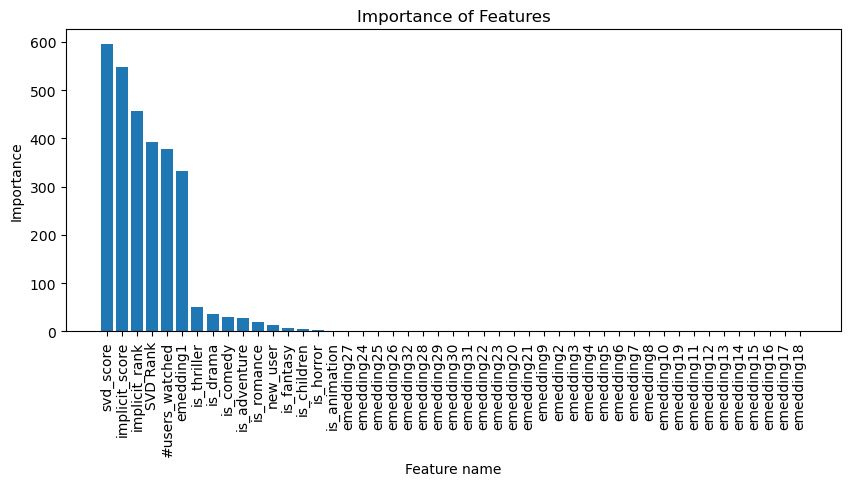

In [480]:
plot_feature_importances(features, importances)

In [481]:
importances

array([549, 456, 596,  29, 378,  14, 333,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  27,
        37,  19,   8,  50,   2,   5,   4, 392])

### No genre 

In [683]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature47))

In [684]:
len(features)

38

In [685]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [686]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                             'implicit_rank': feature2[i], 'svd_score': feature3[i],
                             '#users_watched': feature5[i], 'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'SVD Rank': feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36864769538593717

In [687]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [688]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [689]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.368648,0.336213,0.379561,0.234984,0.202581,0.263836,0.132313,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'SVD Rank'],
      dtype='object')
38
38


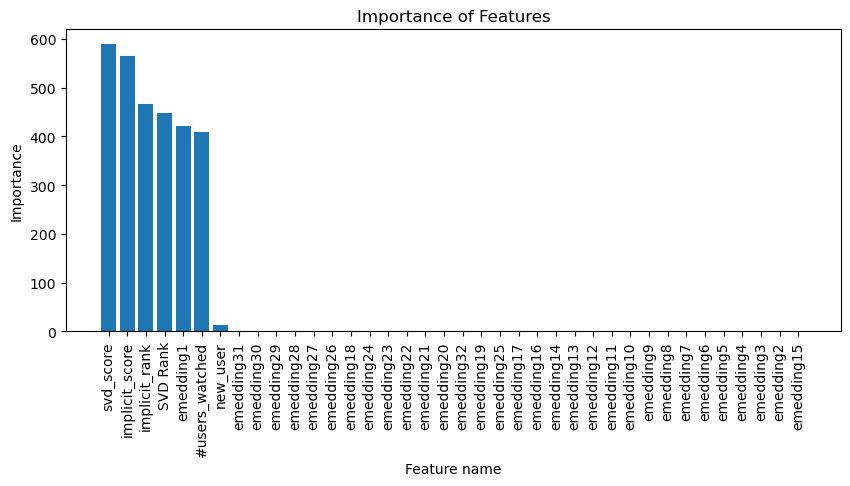

In [680]:
plot_feature_importances(features, importances)

In [681]:
st.spearmanr(np.array(feature2).reshape(len(num_users)*k,), np.array(feature1).reshape(len(num_users)*k,))

SpearmanrResult(correlation=-0.5040190250076356, pvalue=0.0)

In [682]:
#st.spearmanr(np.array(feature9).reshape(len(num_users)*k,), gbm.predict(X_test_no_genre).reshape(len(num_users)*k,))

In [492]:
#pred_no_genre = gbm.predict(X_test_no_genre)
#len(pred_no_genre)

In [493]:
importances

array([566, 466, 590, 410,  14, 421,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 448])

### Each genre's impact

#### Comedy

In [690]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature47))

In [691]:
len(features)

39

In [692]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [693]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3677204642734383

In [694]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [695]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [696]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.36772,0.336213,0.379561,0.233074,0.202581,0.263836,0.131342,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'emedding1', 'emedding2', 'emedding3',
       'emedding4', 'emedding5', 'emedding6', 'emedding7', 'emedding8',
       'emedding9', 'emedding10', 'emedding11', 'emedding12', 'emedding13',
       'emedding14', 'emedding15', 'emedding16', 'emedding17', 'emedding18',
       'emedding19', 'emedding20', 'emedding21', 'emedding22', 'emedding23',
       'emedding24', 'emedding25', 'emedding26', 'emedding27', 'emedding28',
       'emedding29', 'emedding30', 'emedding31', 'emedding32', 'SVD Rank'],
      dtype='object')
39
39


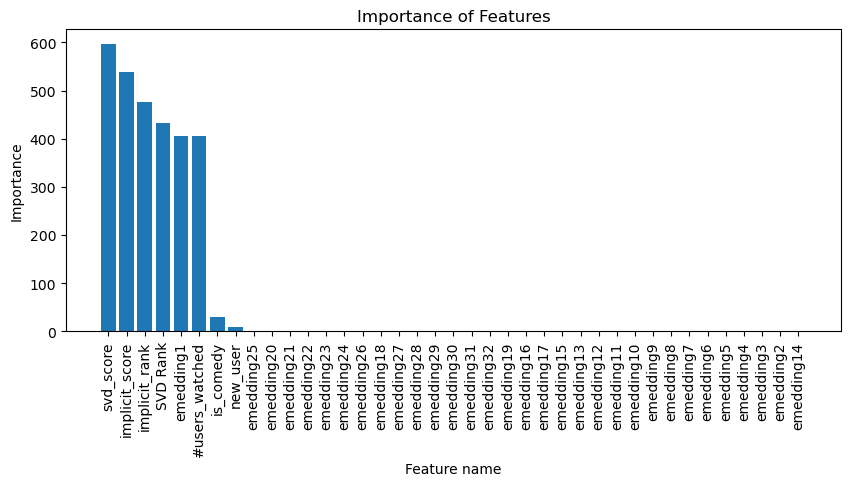

In [501]:
plot_feature_importances(features, importances)

In [502]:
importances

array([539, 476, 597,  30, 405,   9, 406,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 433])

#### Adventure

In [503]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature47))

In [504]:
len(features)

39

In [505]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [506]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3677250606304049

In [507]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [508]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [509]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367725,0.336213,0.379561,0.23269,0.202581,0.263836,0.131367,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_adventure', 'SVD Rank'],
      dtype='object')
39
39


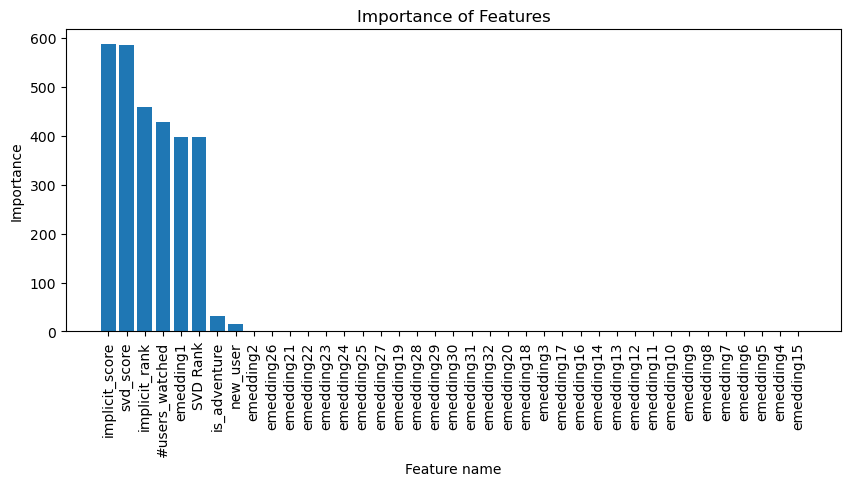

In [510]:
plot_feature_importances(features, importances)

In [511]:
importances

array([588, 459, 585, 428,  15, 397,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32, 397])

#### Drama

In [512]:
features = np.stack((feature1, feature2, feature3, 
                     feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature9,
                     feature47))

In [513]:
len(features)

39

In [514]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [515]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_drama': feature9[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3675055119806943

In [516]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [517]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [518]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367506,0.336213,0.379561,0.234937,0.202581,0.263836,0.130847,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_drama', 'SVD Rank'],
      dtype='object')
39
39


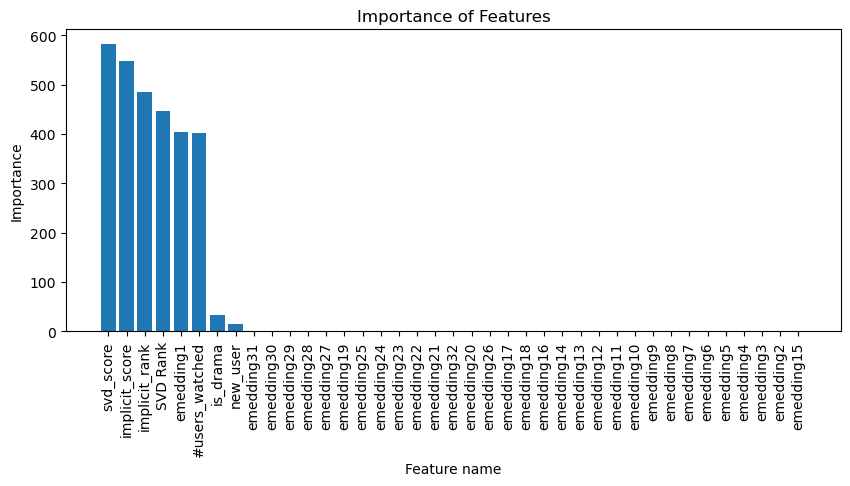

In [519]:
plot_feature_importances(features, importances)

In [520]:
importances

array([549, 486, 583, 403,  15, 405,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  34, 446])

#### Romance

In [521]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature10,
                     feature47))

In [522]:
len(features)

39

In [523]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [524]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_romance': feature10[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3662309766692576

In [525]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [526]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [527]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.366231,0.336213,0.379561,0.228494,0.202581,0.263836,0.12969,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_romance', 'SVD Rank'],
      dtype='object')
39
39


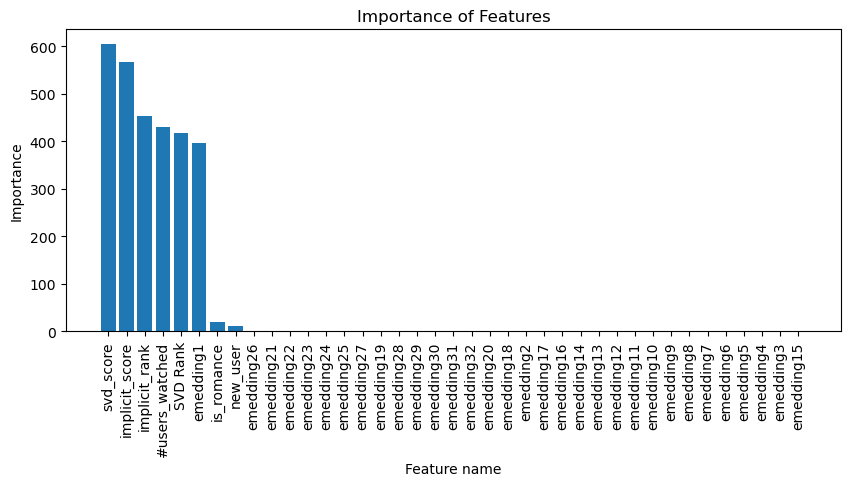

In [528]:
plot_feature_importances(features, importances)

In [529]:
importances

array([566, 454, 605, 431,  11, 397,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  20, 418])

#### Fantasy

In [530]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature11,
                     feature47))

In [531]:
len(features)

39

In [532]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [533]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implcit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_fantasy': feature11[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3684010733244289

In [534]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [535]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [536]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.368401,0.336213,0.379561,0.233094,0.202581,0.263836,0.132069,0.103586,0.14472


Index(['implcit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_fantasy', 'SVD Rank'],
      dtype='object')
39
39


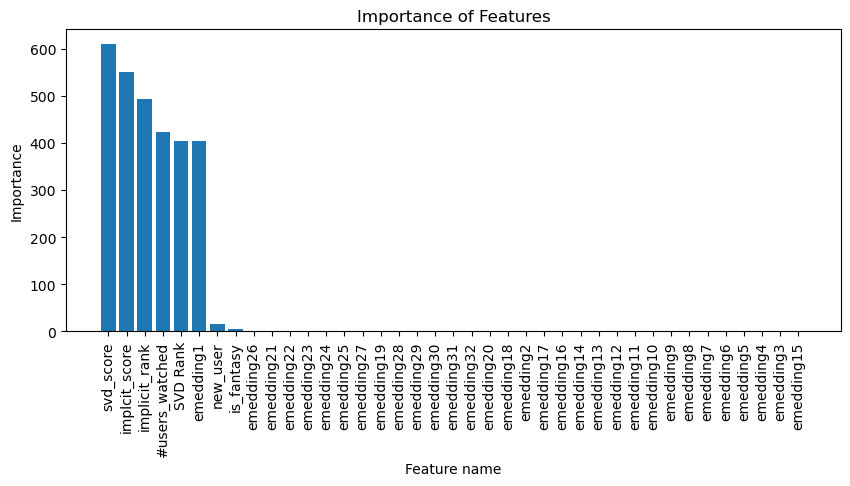

In [537]:
plot_feature_importances(features, importances)

In [538]:
importances

array([551, 492, 610, 423,  15, 403,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 405])

#### Thriller

In [539]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature12,
                     feature47))

In [540]:
len(features)

39

In [541]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [542]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_thriller': feature12[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36711666078005295

In [543]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [544]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [545]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367117,0.336213,0.379561,0.231403,0.202581,0.263836,0.130891,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_thriller', 'SVD Rank'],
      dtype='object')
39
39


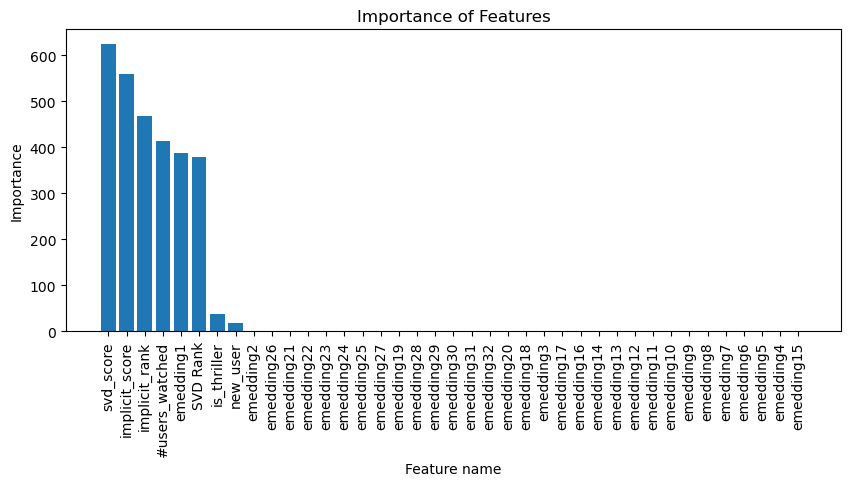

In [546]:
plot_feature_importances(features, importances)

In [547]:
importances

array([560, 468, 625, 414,  18, 388,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  38, 379])

#### Animation

In [548]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature13,
                     feature47))

In [549]:
len(features)

39

In [550]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [551]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_animation': feature13[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3663378206557708

In [552]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [553]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [554]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.366338,0.336213,0.379561,0.230927,0.202581,0.263836,0.12991,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_animation', 'SVD Rank'],
      dtype='object')
39
39


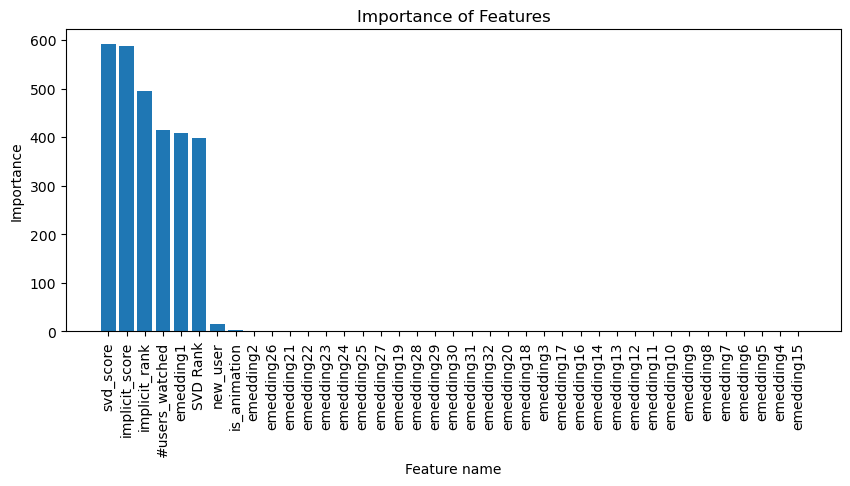

In [555]:
plot_feature_importances(features, importances)

In [556]:
importances

array([587, 495, 592, 414,  15, 409,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3, 399])

#### Children

In [557]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature14,
                     feature47))

In [558]:
len(features)

39

In [559]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [560]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_children': feature14[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36821709828042665

In [561]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [562]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [563]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.368217,0.336213,0.379561,0.237326,0.202581,0.263836,0.131198,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_children', 'SVD Rank'],
      dtype='object')
39
39


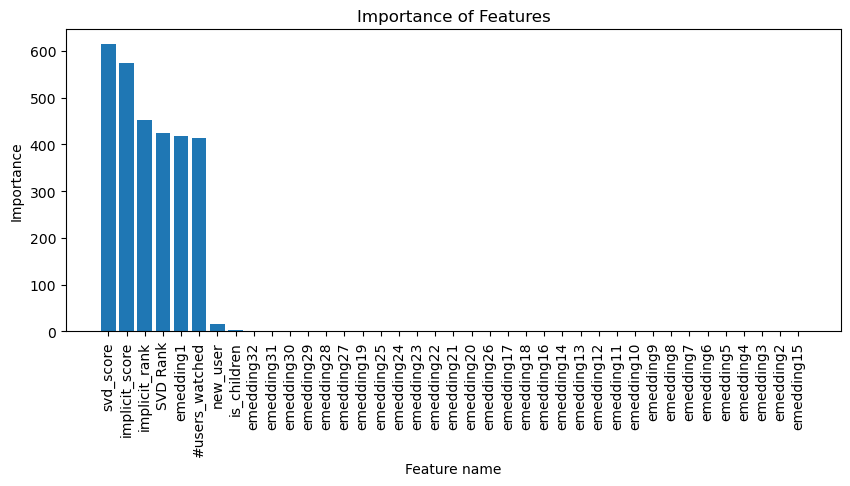

In [564]:
plot_feature_importances(features, importances)

In [565]:
importances

array([573, 452, 615, 413,  15, 417,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4, 424])

#### Horror

In [566]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31], feature15,
                     feature47))

In [567]:
len(features)

39

In [568]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [569]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36748562910787863

In [570]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [571]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [572]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367486,0.336213,0.379561,0.234188,0.202581,0.263836,0.130853,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_horror', 'SVD Rank'],
      dtype='object')
39
39


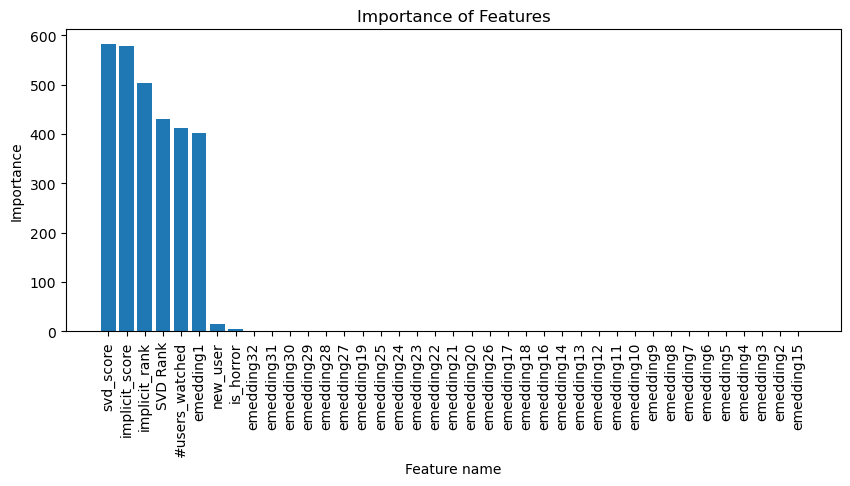

In [573]:
plot_feature_importances(features, importances)

In [574]:
importances

array([578, 503, 583, 412,  16, 402,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4, 430])

### Keeping the top genres

In [575]:
features = np.stack((feature1, feature2, feature3, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature47))

In [576]:
len(features)

40

In [577]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [578]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                             'implicit_rank': feature2[i], 'svd_score': feature3[i],
                             '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_adventure': feature8[i], 'is_drama': feature9[i], 'SVD Rank': feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3689590863103912

In [579]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [580]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [581]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.368959,0.336213,0.379561,0.234618,0.202581,0.263836,0.132506,0.103586,0.14472


Index(['implicit_score', 'implicit_rank', 'svd_score', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_adventure', 'is_drama',
       'SVD Rank'],
      dtype='object')
40
40


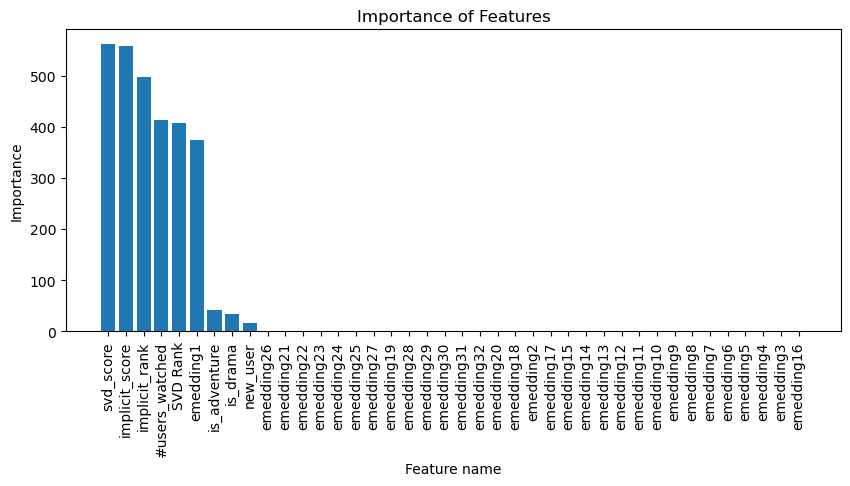

In [582]:
plot_feature_importances(features, importances)

In [583]:
importances

array([557, 498, 562, 413,  16, 375,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42,  35,
       407])

## What is the impact of items' embeddings features on the effectiveness of a model for item recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 


### No item embeddings features

In [584]:
features = np.stack((feature1,feature2,feature3,feature4,feature5,feature6,feature8,
                              feature9,feature10,feature11,feature12,feature13,
                              feature14,feature15,feature47))

In [585]:
len(features)

15

In [586]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [587]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3678390047237293

In [588]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [589]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [590]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367839,0.336213,0.379561,0.233478,0.202581,0.263836,0.131607,0.103586,0.14472


In [591]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'is_adventure', 'is_drama', 'is_romance',
       'is_fantasy', 'is_thriller', 'is_animation', 'is_children', 'is_horror',
       'SVD Rank'],
      dtype='object')
15
15


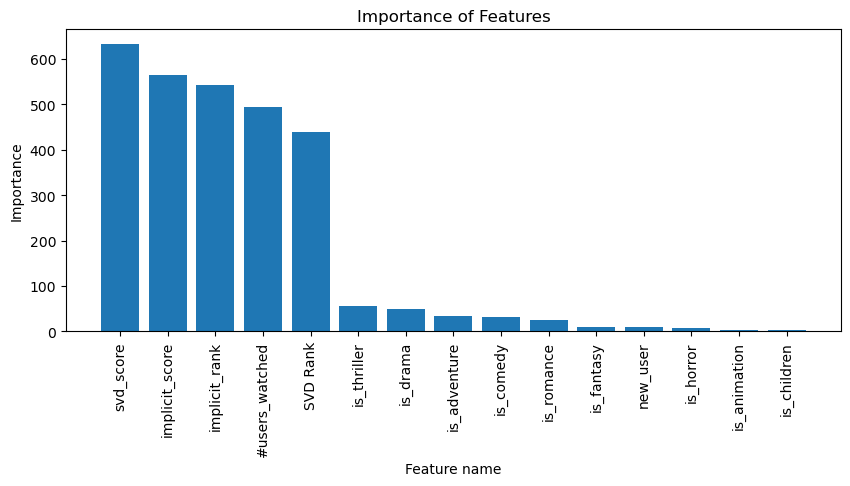

In [592]:
plot_feature_importances(features, importances)

In [593]:
importances

array([565, 543, 633,  32, 494,   9,  35,  50,  25,  10,  55,   4,   3,
         8, 439])

### First Embedding only

In [594]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature8,
                     feature9, feature10, feature11, feature12, feature13,
                     feature14, feature15, feature47))

In [595]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [596]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'implicit_rank': feature2[i], 'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36659439268665694

In [597]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [598]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [599]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.366594,0.336213,0.379561,0.227145,0.202581,0.263836,0.13052,0.103586,0.14472


In [600]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'emedding1', 'is_adventure', 'is_drama',
       'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror', 'SVD Rank'],
      dtype='object')
16
16


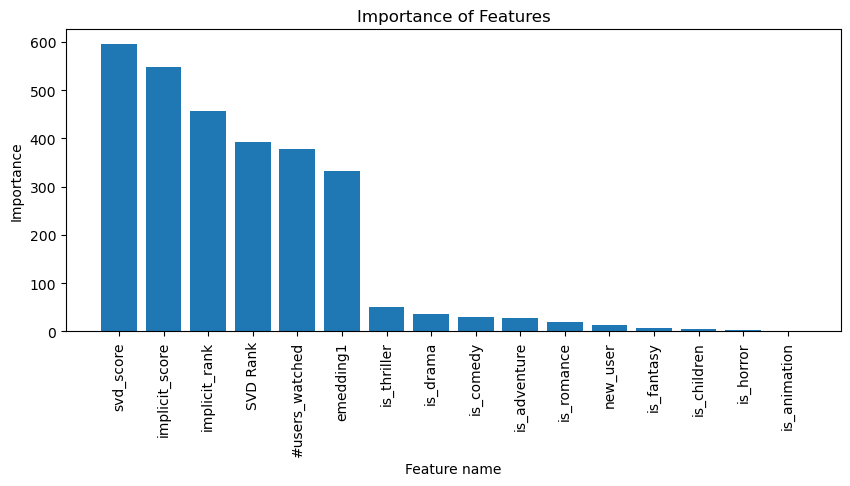

In [601]:
plot_feature_importances(features, importances)

In [602]:
importances

array([549, 456, 596,  29, 378,  14, 333,  27,  37,  19,   8,  50,   2,
         5,   4, 392])

## What is the impact of the items’rank on the effectiveness of amodel for item recommendations?

1. Post-hoc analysis
2. Spearman correlation
try different features, see what happens, and analyze it to explain. 


### No models' rank features

In [603]:
features = np.stack((feature1, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15))

In [604]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [605]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36868390599070067

In [606]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [607]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [608]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.368684,0.336213,0.379561,0.235202,0.202581,0.263836,0.133241,0.103586,0.14472


In [609]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'svd_score', 'is_comedy', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_adventure', 'is_drama',
       'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror'],
      dtype='object')
45
45


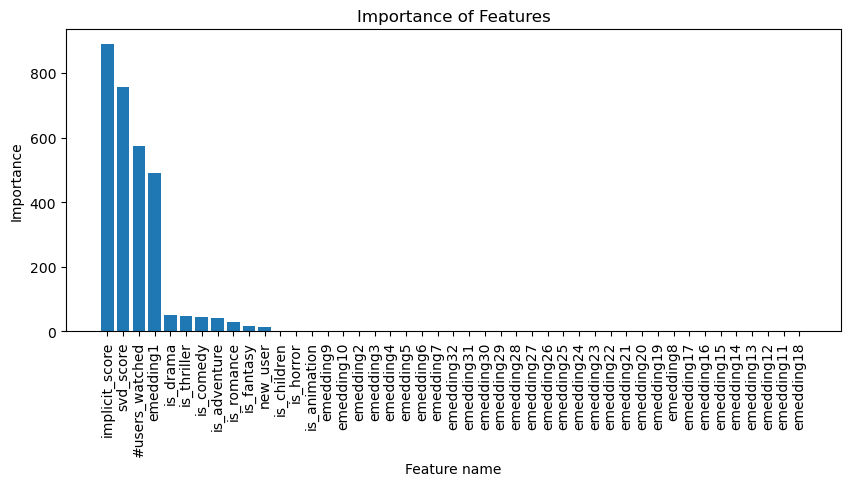

In [610]:
plot_feature_importances(features, importances)

In [611]:
importances

array([890, 757,  46, 573,  15, 491,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  43,  52,
        29,  17,  49,   1,   3,   3])

### Without Implicit Rank

In [612]:
features = np.stack((feature1, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [613]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [614]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                         'svd_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD_rank':feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3707837755339866

In [615]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [616]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [617]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.370784,0.336213,0.379561,0.241274,0.202581,0.263836,0.134977,0.103586,0.14472


In [618]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'svd_score', 'is_comedy', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_adventure', 'is_drama',
       'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror', 'SVD_rank'],
      dtype='object')
46
46


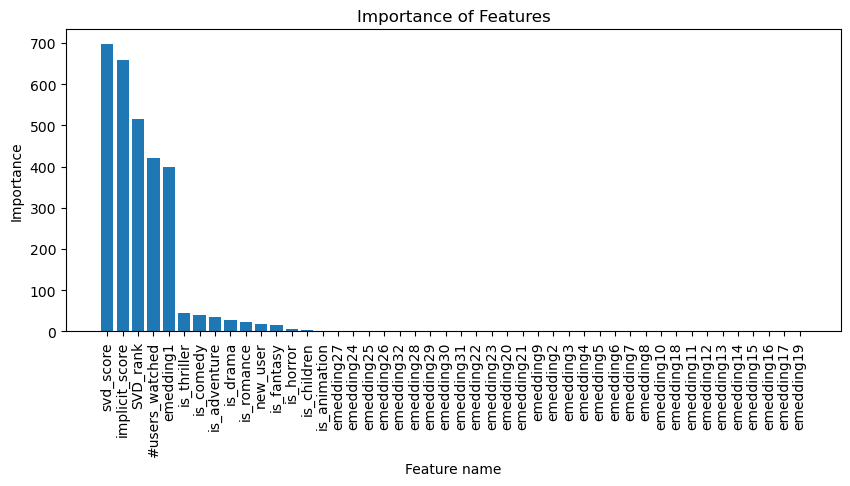

In [619]:
plot_feature_importances(features, importances)

In [620]:
importances

array([659, 698,  39, 421,  17, 398,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  34,  28,
        22,  15,  44,   2,   3,   5, 515])

### Without SVD Rank

In [621]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15))

In [622]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [623]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'implicit_score': feature1[i],
                             'implicit_rank': feature2[i], 'svd_score': feature3[i],
                             'is_comedy': feature4[i], '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                             'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                             'is_children': feature14[i], 'is_horror': feature15[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.367807132945817

In [624]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [625]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [626]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.367807,0.336213,0.379561,0.237638,0.202581,0.263836,0.13123,0.103586,0.14472


In [627]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['implicit_score', 'implicit_rank', 'svd_score', 'is_comedy',
       '#users_watched', 'new_user', 'emedding1', 'emedding2', 'emedding3',
       'emedding4', 'emedding5', 'emedding6', 'emedding7', 'emedding8',
       'emedding9', 'emedding10', 'emedding11', 'emedding12', 'emedding13',
       'emedding14', 'emedding15', 'emedding16', 'emedding17', 'emedding18',
       'emedding19', 'emedding20', 'emedding21', 'emedding22', 'emedding23',
       'emedding24', 'emedding25', 'emedding26', 'emedding27', 'emedding28',
       'emedding29', 'emedding30', 'emedding31', 'emedding32', 'is_adventure',
       'is_drama', 'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror'],
      dtype='object')
46
46


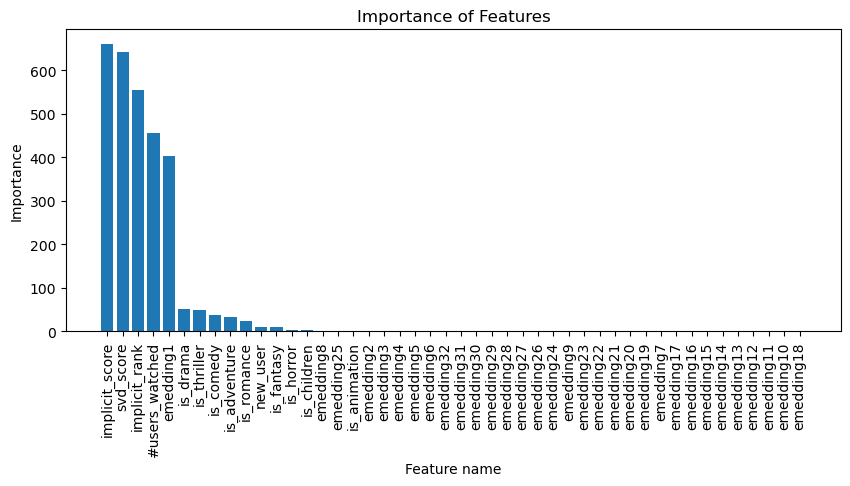

In [628]:
plot_feature_importances(features, importances)

In [629]:
importances

array([661, 556, 643,  37, 455,  10, 404,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  34,
        52,  25,  10,  50,   0,   3,   4])

## What is the impact of the baseline scores?

### No models' scores

In [630]:
features = np.stack((feature2, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [631]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [632]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'IFM_rank': feature2[i],
                             'is_comedy': feature4[i], '#users_watched': feature5[i],
                             'new_user': feature6[i],
                             'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                             'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                             'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                             'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                             'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                             'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                             'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                             'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                             'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                             'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                             'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                             'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                             'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                             'is_children': feature14[i], 'is_horror': feature15[i], 'SVD_rank':feature47[i],
                             'train_label': label_train[i], 'test_label': label_test[i],
                             'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3690318934947863

In [633]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [634]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [635]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.369032,0.336213,0.379561,0.25013,0.202581,0.263836,0.131288,0.103586,0.14472


In [636]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['IFM_rank', 'is_comedy', '#users_watched', 'new_user', 'emedding1',
       'emedding2', 'emedding3', 'emedding4', 'emedding5', 'emedding6',
       'emedding7', 'emedding8', 'emedding9', 'emedding10', 'emedding11',
       'emedding12', 'emedding13', 'emedding14', 'emedding15', 'emedding16',
       'emedding17', 'emedding18', 'emedding19', 'emedding20', 'emedding21',
       'emedding22', 'emedding23', 'emedding24', 'emedding25', 'emedding26',
       'emedding27', 'emedding28', 'emedding29', 'emedding30', 'emedding31',
       'emedding32', 'is_adventure', 'is_drama', 'is_romance', 'is_fantasy',
       'is_thriller', 'is_animation', 'is_children', 'is_horror', 'SVD_rank'],
      dtype='object')
45
45


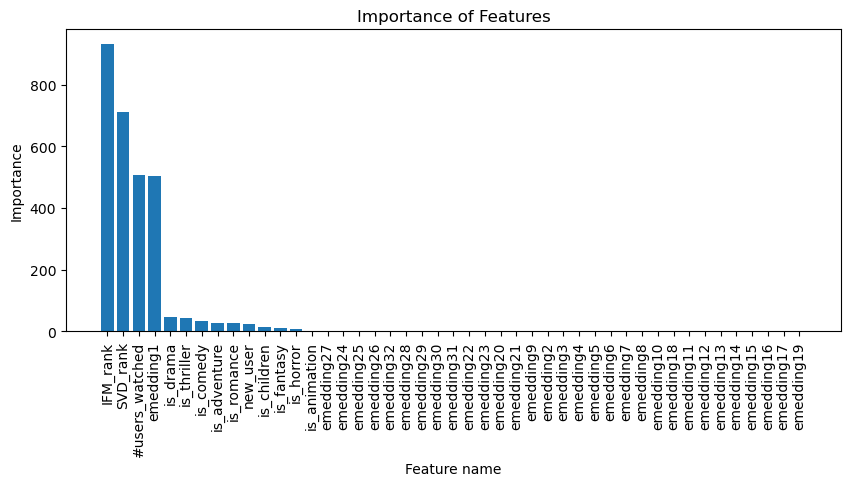

In [637]:
plot_feature_importances(features, importances)

In [638]:
importances

array([932,  35, 508,  25, 503,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  29,  48,  26,
        10,  45,   3,  13,   8, 711])

### Without IFM's score

In [639]:
features = np.stack((feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [640]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [641]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'ifm_rank':feature2[i],
                         'model2_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD_rank':feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36966002527961456

In [642]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [643]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [644]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.36966,0.336213,0.379561,0.24325,0.202581,0.263836,0.132651,0.103586,0.14472


In [645]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['ifm_rank', 'model2_score', 'is_comedy', '#users_watched', 'new_user',
       'emedding1', 'emedding2', 'emedding3', 'emedding4', 'emedding5',
       'emedding6', 'emedding7', 'emedding8', 'emedding9', 'emedding10',
       'emedding11', 'emedding12', 'emedding13', 'emedding14', 'emedding15',
       'emedding16', 'emedding17', 'emedding18', 'emedding19', 'emedding20',
       'emedding21', 'emedding22', 'emedding23', 'emedding24', 'emedding25',
       'emedding26', 'emedding27', 'emedding28', 'emedding29', 'emedding30',
       'emedding31', 'emedding32', 'is_adventure', 'is_drama', 'is_romance',
       'is_fantasy', 'is_thriller', 'is_animation', 'is_children', 'is_horror',
       'SVD_rank'],
      dtype='object')
46
46


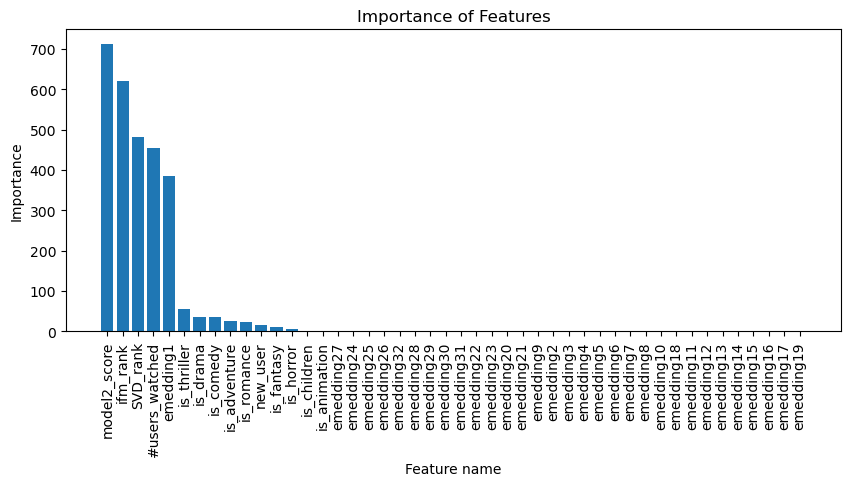

In [646]:
plot_feature_importances(features, importances)

In [647]:
importances

array([620, 713,  37, 456,  16, 385,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  25,  37,
        23,  10,  55,   1,   2,   7, 483])

### Without SVD's score

In [648]:
features = np.stack((feature1, feature2, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [649]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [650]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i], 
                         'ifm_rank': feature2[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'svd_rank':feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.3646985590790983

In [651]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [652]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [653]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.364699,0.336213,0.379561,0.231765,0.202581,0.263836,0.127551,0.103586,0.14472


In [654]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['model1_score', 'ifm_rank', 'is_comedy', '#users_watched', 'new_user',
       'emedding1', 'emedding2', 'emedding3', 'emedding4', 'emedding5',
       'emedding6', 'emedding7', 'emedding8', 'emedding9', 'emedding10',
       'emedding11', 'emedding12', 'emedding13', 'emedding14', 'emedding15',
       'emedding16', 'emedding17', 'emedding18', 'emedding19', 'emedding20',
       'emedding21', 'emedding22', 'emedding23', 'emedding24', 'emedding25',
       'emedding26', 'emedding27', 'emedding28', 'emedding29', 'emedding30',
       'emedding31', 'emedding32', 'is_adventure', 'is_drama', 'is_romance',
       'is_fantasy', 'is_thriller', 'is_animation', 'is_children', 'is_horror',
       'svd_rank'],
      dtype='object')
46
46


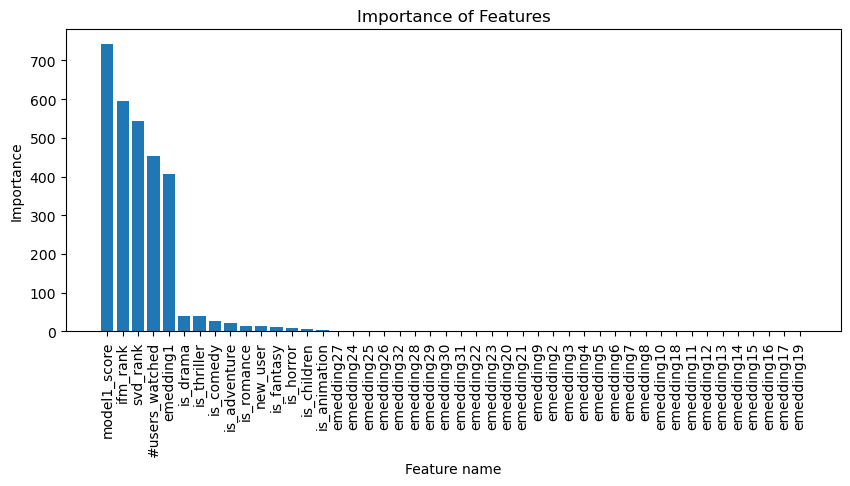

In [655]:
plot_feature_importances(features, importances)

In [656]:
importances

array([743, 596,  28, 453,  13, 406,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  23,  40,
        13,  11,  39,   4,   7,   9, 544])

## Best feature combinations

In [657]:
features = np.stack((feature1, feature2, feature3, feature4, feature5, feature6,
                     feature7[0], feature7[1], feature7[2], feature7[3],
                     feature7[4], feature7[5], feature7[6], feature7[7],
                     feature7[8], feature7[9], feature7[10], feature7[11],
                     feature7[12], feature7[13], feature7[14], feature7[15],
                     feature7[16], feature7[17], feature7[18], feature7[19],
                     feature7[20], feature7[21], feature7[22], feature7[23],
                     feature7[24], feature7[25], feature7[26], feature7[27],
                     feature7[28], feature7[29], feature7[30], feature7[31],
                     feature8, feature9, feature10, feature11, feature12,
                     feature13, feature14, feature15, feature47))

In [658]:
len(features)

47

In [659]:
X_train, X_test, X_val = prepareXY(features)
lgbm_pred_per_user, importances = lgbm_fit_predict(X_train, y_train, group_train, X_val, y_val, group_val, X_test)

2


In [660]:
lgbm_NDCG = []
lgbm_relevance_list = []
for i in range(len(num_users)):
    excel_df = pd.DataFrame({'movie_id': target_movies[i], 'model1_score': feature1[i],
                         'rank': feature2[i], 'model2_score': feature3[i],
                         'is_comedy': feature4[i], '#users_watched': feature5[i],
                         'new_user': feature6[i],
                         'emedding1': feature7[0][i], 'emedding2': feature7[1][i], 'emedding3': feature7[2][i],
                         'emedding4': feature7[3][i], 'emedding5': feature7[4][i], 'emedding6': feature7[5][i],
                         'emedding7': feature7[6][i], 'emedding8': feature7[7][i], 'emedding9': feature7[8][i],
                         'emedding10': feature7[9][i], 'emedding11': feature7[10][i], 'emedding12': feature7[11][i],
                         'emedding13': feature7[12][i], 'emedding14': feature7[13][i], 'emedding15': feature7[14][i],
                         'emedding16': feature7[15][i], 'emedding17': feature7[16][i], 'emedding18': feature7[17][i],
                         'emedding19': feature7[18][i], 'emedding20': feature7[19][i], 'emedding21': feature7[20][i],
                         'emedding22': feature7[21][i], 'emedding23': feature7[22][i], 'emedding24': feature7[23][i],
                         'emedding25': feature7[24][i], 'emedding26': feature7[25][i], 'emedding27': feature7[26][i],
                         'emedding28': feature7[27][i], 'emedding29': feature7[28][i], 'emedding30': feature7[29][i],
                         'emedding31': feature7[30][i], 'emedding32': feature7[31][i],
                         'is_adventure': feature8[i], 'is_drama': feature9[i], 'is_romance': feature10[i],
                         'is_fantasy': feature11[i], 'is_thriller': feature12[i], 'is_animation': feature13[i],
                         'is_children': feature14[i], 'is_horror': feature15[i], 'SVD Rank': feature47[i],
                         'train_label': label_train[i], 'test_label': label_test[i],
                         'y_val': label_val[i], 'LGBM Score': lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score', ascending=False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_relevance_list.append(relevance_lgbm_user)
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
lgbm_NDCG = np.mean(lgbm_NDCG)
lgbm_NDCG

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


0.36659439268665694

In [661]:
lgbm_mrr, lgbm_map = mrr_map(lgbm_relevance_list)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [662]:
metrics_df = compare_metrics(lgbm_NDCG, lgbm_mrr, lgbm_map)

In [663]:
metrics_df

,LightGBM_NDCG,IFM_NDCG,SVD_NDCG,LightGBM_MRR,IFM_MRR,SVD_MRR,LightGBM_MAP,IFM_MAP,SVD_MAP
0,0.366594,0.336213,0.379561,0.227145,0.202581,0.263836,0.13052,0.103586,0.14472


In [664]:
metrics_df.to_csv(r'C:\Users\papad\Desktop\DISS WRITE\d.csv', index = False)

Index(['model1_score', 'rank', 'model2_score', 'is_comedy', '#users_watched',
       'new_user', 'emedding1', 'emedding2', 'emedding3', 'emedding4',
       'emedding5', 'emedding6', 'emedding7', 'emedding8', 'emedding9',
       'emedding10', 'emedding11', 'emedding12', 'emedding13', 'emedding14',
       'emedding15', 'emedding16', 'emedding17', 'emedding18', 'emedding19',
       'emedding20', 'emedding21', 'emedding22', 'emedding23', 'emedding24',
       'emedding25', 'emedding26', 'emedding27', 'emedding28', 'emedding29',
       'emedding30', 'emedding31', 'emedding32', 'is_adventure', 'is_drama',
       'is_romance', 'is_fantasy', 'is_thriller', 'is_animation',
       'is_children', 'is_horror', 'SVD Rank'],
      dtype='object')
47
47


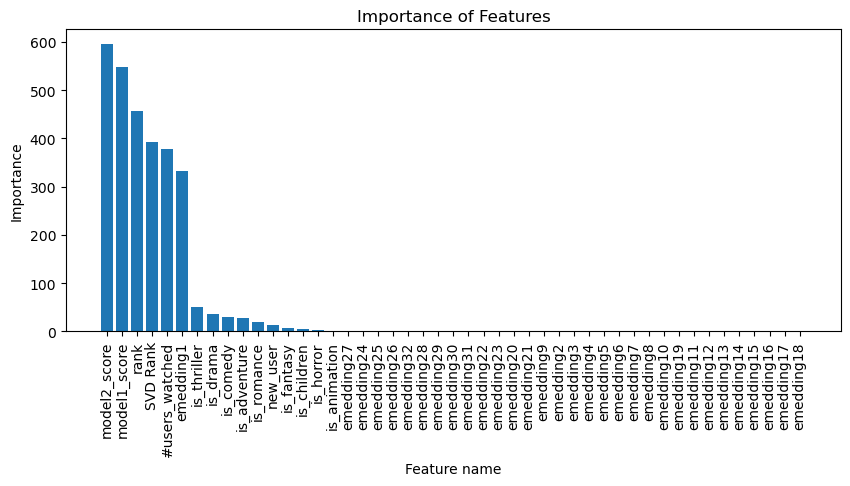

In [665]:
plot_feature_importances(features, importances)

In [666]:
importances

array([549, 456, 596,  29, 378,  14, 333,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  27,
        37,  19,   8,  50,   2,   5,   4, 392])

# Draft

## LGBM Classifier

## Excel-Like

In [667]:
excel1_df = pd.DataFrame({'movie_id': target_movies[0],'rank':feature2[0],'model1_score':feature1[0], 'model2_score':feature3[0],'is_comedy':feature4[0],
                            '#users_watched':feature5[0], 'train_label':label_train[0], 'test_label':label_test[0],
                            'label_val':label_val[0],'LGBM Score':lgbm_pred_per_user[0]})

In [668]:
excel1_df

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
0,296,1.0,14.026933,0.334270,1,861,0,0,1,-0.168375
1,527,2.0,12.409852,0.350174,0,630,0,0,0,-0.865316
2,111,2.0,12.303709,0.186094,0,290,0,0,0,-1.337731
3,47,4.0,11.927846,0.238047,0,548,0,0,0,-0.764375
4,586,4.0,11.774894,-0.025215,1,295,0,0,0,-2.465356
...,...,...,...,...,...,...,...,...,...,...
145,67087,2879.0,0.187322,0.002540,1,29,0,0,0,-3.087531
146,2791,5156.0,7.453169,0.038899,1,222,0,0,0,-2.424958
147,203204,5284.0,-5.158163,0.004027,0,1,0,0,0,-3.117519
148,480,8300.0,11.442561,0.029014,0,693,0,0,0,-0.992510


In [669]:
excel1_df = excel1_df.sort_values('LGBM Score',ascending = False)
excel1_df.head(10)

,movie_id,rank,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
90,2571,247.0,9.626532,0.367629,0,780,0,0,0,0.460116
50,2959,83.0,10.260109,0.439443,0,611,0,0,0,0.435189
54,593,88.0,10.217089,0.212248,0,793,0,0,0,0.230098
33,858,45.0,10.637561,0.445186,0,545,0,0,0,0.160359
28,79132,35.0,10.799676,0.349097,0,402,0,0,0,0.149236
101,356,355.0,11.165468,0.169832,1,872,0,0,0,0.051080
17,356,19.0,11.165468,0.169832,1,872,0,0,0,0.043272
60,6016,128.0,10.123776,0.268547,0,193,0,0,0,0.011338
32,260,44.0,10.736603,0.182911,0,722,0,0,0,0.009170
25,55247,33.0,10.916847,0.141934,0,114,0,0,0,-0.029073


In [670]:
relevance_lgbm_firstUser = excel1_df['test_label'].values.tolist()

In [671]:
L1GBM_ndcg = NDCG_forUser(relevance_lgbm_firstUser)
L1GBM_ndcg

0.1631512196835108

In [672]:
from sklearn.metrics import dcg_score
true = np.asarray([actual])
pred = np.asarray([predicted_rank_svd])
dcg = dcg_score(true,pred)
idcg = dcg_score(true,true)
ndcg = dcg/idcg

NameError: name 'predicted_rank_svd' is not defined

In [ ]:
ndcg

In [ ]:
from sklearn.metrics import ndcg_score
n = ndcg_score(true,pred)
n

In [ ]:
'''relevance = []
for i in range(20,40):
    if predicted_rank_svd[i] in actual:
        relevance.append(1)
    else:
        relevance.append(0)'''

In [ ]:
svd_rank_allUsers = []
for i in range(1,len(num_users)+1):
    already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
    svd_rank_allUsers.append(predictions['movieId'].index.tolist()) 


In [ ]:
'''def NDCG_forUser_SVD(user):
    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'''

In [ ]:
'''NDCG_SVD = NDCG_forUser_SVD(2)'''

In [ ]:
'''NDCG_SVD'''

Take as features the predicted ratings for the users of SVD and Implicit for the next step?

## KNN

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [ ]:
df_movie_features = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [ ]:
df_movie_features

In [ ]:
height = [len(df_movie_features.values[df_movie_features.values== 0]),len(df_movie_features.values[df_movie_features.values==0.5]),
          len(df_movie_features.values[df_movie_features.values== 1]),len(df_movie_features.values[df_movie_features.values==1.5]),
          len(df_movie_features.values[df_movie_features.values== 2]),len(df_movie_features.values[df_movie_features.values==2.5]),
          len(df_movie_features.values[df_movie_features.values== 3]),len(df_movie_features.values[df_movie_features.values==3.5]),
          len(df_movie_features.values[df_movie_features.values== 4]),len(df_movie_features.values[df_movie_features.values==4.5]),
          len(df_movie_features.values[df_movie_features.values== 5])]
x = ('0','0.5', '1','1.5' ,'2','2.5', '3','3.5', '4','4.5','5')
plt.bar(x, height)
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()


A lot of ratings in the user-movie matrix are zero, so the data are extremely sparse.

To makes sesne the idea of obtaining the taste of the users, they should have rated at least 20 movies. Otherwise, the taste of them is not clear. The users that have rated less than 20 movies will be excluded. Also the movies that have less than 20 ratings will be excluded too.

In [ ]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(ratings_df)

In [ ]:
ratings_df[24400:24450]

In [ ]:
excel_df

## Implicit Sequence model

In [ ]:
from spotlight.sequence.implicit import ImplicitSequenceModel
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel

### Train Implicit Sequence model

In [ ]:
'''sequence_model  = ImplicitSequenceModel(n_iter = 5)

current = time.time()
sequence_model.fit(interactions = implicit_train.to_sequence(),verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))'''

In [ ]:
#sequence_model.predict(sequences = 9724)

### MRR Score

In [ ]:
#print(sequence_mrr_score(sequence_model, implicit_test.to_sequence()).mean())

### Top-K predictions for a user

In [ ]:
#allUsers_topK_sequence = allUsers_topK_implicit(sequence_model)

### NDCG Score

In [ ]:
#relevance_sequence_full = relevance_spotlight_implicit(allUsers_topK_sequence)

In [ ]:
#allUsers_sequence_ndcg = allUsers_ndcg(relevance_sequence_full)

In [ ]:
#allUsers_sequence_ndcg = pd.Series(allUsers_sequence_ndcg).fillna(0).tolist()

### MAP

In [ ]:
'''ran = [1,0,1,1,0]
ran = r2
count_positive = 0
positives = []
ap_perUser = []
count = 0
for r in ran:
    #for i in range(len(relevance[0])):
    count += 1
    if r == 1:
        count_positive += 1
        positives.append(count_positive/count)
ap_perUser.append(np.array(positives).sum()/count_positive)
count_positive = 0
positives = []'''

In [ ]:
#ap_perUser

In [ ]:
r_f = []
r_f.append([1,0,1,1,0])
r_f.append([0,0,0,1,1])

In [ ]:
r_f

In [ ]:
rap = calculate_averagePrecision(r_f)

In [ ]:
rap

In [ ]:
rmap = calculate_MAP(rap)
rmap

### MRR

In [ ]:
len(af)

In [ ]:
afrr = RR_forUsers(af)
mrr_af = calculate_mrr(afrr)

In [ ]:
mrr_af

### Built-in MRR score

In [ ]:
from spotlight.evaluation import mrr_score
print(mrr_score(implicit_model, implicit_test, train=implicit_train, k=100).mean())

### Second NDCG Score

Code used from https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

Provide top-K predictions for a user

In [ ]:
'''def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations'''

In [ ]:
'''already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)
predictions.head()'''

The function SVD_topK_allUsers returens a list that contains the top-K recommendations for each user.

In [ ]:
'''def SVD_topK_allUsers():
    allUsers_already_rated = []
    allUsers_predictions = []
    for i in range(1,len(num_users)+1):
        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
        allUsers_already_rated.append(already_rated)
        allUsers_predictions.append(predictions)
    return allUsers_predictions'''

#### NDCG Score

The function SVD_relevance returns a list that contains the relevance (0s and 1s) between the top-K recommendations and the movies that each user actually watched.

In [ ]:
'''def SVD_relevance():
    svd_topK = SVD_topK_allUsers()
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full'''

In [ ]:
#svd_relevance = SVD_relevance()

In [ ]:
#allUsers_svd_ndcg = allUsers_ndcg(svd_relevance)